# ***Предсказание температуры стали***

## 1. Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

## 2. Описание данных

Данные хранятся в `Sqlite` СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.  

Таблица `steel.data_arc`
- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.  

Таблица `steel.data_bulk`
- `key` — номер партии;
- `Bulk1` … `Bulk15` — объём подаваемого материала.  

Таблица `steel.data_bulk_time`
- `key` — номер партии;
- `Bulk1` … `Bulk15` — время подачи материала.  

Таблица `steel.data_gas`
- `key` — номер партии;
- `gas` — объём подаваемого газа.  

Таблица `steel.data_temp`
- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.  

Таблица `steel.data_wire`
- `key` — номер партии;
- `Wire1` … `Wire9` — объём подаваемых проволочных материалов.  

Таблица `steel.data_wire_time`
- `key` — номер партии;
- `Wire1` … `Wire9` — время подачи проволочных материалов.  

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.  
Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные. Для оценки модели должна использоваться метрика MAE, значение которой должно быть менее 6.8.

## 3. Подготовка среды

In [110]:
try:
    import phik
except:
    !pip install phik -q
    import phik

try:
    import shap
except:
    !pip install shap -q
    import shap

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import random
from pandas.api.types import is_string_dtype
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sqlalchemy import create_engine, inspect, text

In [112]:
sns.set()

In [113]:
RANDOM_STATE = 210425
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
ALPHA = 0.05
TEST_SIZE = 0.25
path_to_db = "ds-plus-final.db" # Путь к базе данных

In [114]:
# Скачать файл с базой данных по ссылке
if not os.path.isfile(path_to_db):
    !wget -q "https://code.s3.yandex.net/.../ds-plus-final.db"

##  4. Исследовательский анализ и предобработка данных

Создадим соединение с базой.

In [24]:
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

Проверим, существуют ли нужные таблицы в базе данных.

In [25]:
# Словарь с описаниями и названиями таблиц
tables = {
    'Данные об электродах': 'data_arc',
    'Данные об объёме сыпучих материалов': 'data_bulk',
    'Данные о времени подачи сыпучих материалов': 'data_bulk_time',
    'Данные о продувке сплава газом': 'data_gas',
    'Данные об измерениях температуры': 'data_temp',
    'Данные об объёме проволочных материалов': 'data_wire',
    'Данные о времени подачи проволочных материалов': 'data_wire_time'
}

In [26]:
inspector = inspect(engine)
for table in tables.values():
    # Проверяем, что таблица существует
    exists = inspector.has_table(table)
    print(f"Таблица {table} существует." if exists else f"Таблица {table} не найдена.")
    if exists:
        with engine.connect() as conn:
            # Проверяем, что в таблице есть хотя бы одна строка  
            result = conn.execute(text(f"SELECT 1 FROM {table} LIMIT 1"))
            has_data = result.fetchone() is not None
            print(f" В {table} есть данные." if exists else f"В {table} данных нет.")

Таблица data_arc существует.
 В data_arc есть данные.
Таблица data_bulk существует.
 В data_bulk есть данные.
Таблица data_bulk_time существует.
 В data_bulk_time есть данные.
Таблица data_gas существует.
 В data_gas есть данные.
Таблица data_temp существует.
 В data_temp есть данные.
Таблица data_wire существует.
 В data_wire есть данные.
Таблица data_wire_time существует.
 В data_wire_time есть данные.


Загрузим данные в датафреймы.

In [27]:
dfs = {} # Словарь с датафреймами

query = '''
SELECT *
FROM {}
'''
for table in tables.keys():
    dfs[table] = pd.read_sql_query(query.format(tables[table]), con = engine)

Для знакомства с данными используем вспомогательные функции.

In [28]:
# напишем функции для правописания слов "столбец" и "строка"
def row_word(row_num):
    if str(row_num)[-1] == '1':
        return 'строка'
    elif str(row_num)[-1] in '234' and row_num not in [11, 12, 13, 14]:
        return 'строки'
    else:
        return 'строк'

def col_word(col_num):
    if str(col_num)[-1] == '1':
        return 'столбец'
    elif str(col_num)[-1] in '234' and col_num not in [11, 12, 13, 14]:
        return 'столбца'
    else:
        return 'столбцов'

# напишем функцию для знакомства с датафреймом
def df_inf(df, description, print_text=True):
    print(f'\nРассмотрим датафрейм {description}.\n')
    df.info()
    display(df.head().T)

    # подсчет строковых столбцов
    obj_col_num = 0
    for i in df.columns:
        if is_string_dtype(df[i]):
            obj_col_num += 1

    # подсчет строк и столбцов
    row_num = df.shape[0]
    col_num = df.shape[1]
    
    if print_text:
        print(f'\nВ датафрейме {row_num} {row_word(row_num)} и {col_num} {col_word(col_num)}. Из них {obj_col_num}'
            f' {col_word(obj_col_num)} со строковыми значениями и {col_num - obj_col_num} с числовыми.')
    
# подсчет столбцов с пропусками, и составление списков такий колонок и количеств пропусков
    nan_col_num = 0
    nan_col_list = []
    nan_num_list = []
    for col in df.columns:
        nan_num = df[col].isna().sum()
        if nan_num > 0:
            nan_col_num += 1
            nan_col_list.append(col)
            nan_num_list.append(nan_num)
# составление таблицы пропусков
    if len(nan_col_list) > 0:
        nan_table = pd.DataFrame({'Столбец': nan_col_list,
                                  'Количество_пропусков': nan_num_list,})
        nan_table['Доля_пропусков'] = nan_table['Количество_пропусков'] / df.shape[0]
   
    if nan_col_num == 0:
        print(f'Пропущенных значений в датафрейме нет.')
    else:
        print(f'{nan_col_num} {col_word(nan_col_num)} {nan_col_list} содержат пропущенные значения.')

    if len(nan_col_list) > 0:
        display(nan_table)

Кроме того, напишем фунцию для вывода статистик и графиков, характеризующих исследуемый признак.

In [29]:
def describe_feature(df,
                     column,
                     bins=100,
                     as_cat=False,
                     num_unique=50,
                     norm_test=True,
                     min_p_value=0.00001,
                     figsize=(10, 4),
                     target=None ):
    """
    Для строковых столбцов функция выводит частотную таблицу и круговую диаграмму или
    столбчатый график (при количестве уникальных значений признака большем 3-х).
    Если передан целевой признак, выводится столбчатый график медианных значений целевого
    признака для категорий исследуемого категориального признака. В задаче регрессии 
    выводится столбчатый график медианных значений целевого признака для категорий 
    рассматриваемого параметра. В задаче классификации - гистограмма категорий признака
    с детализацией по целевым классам.

    Если as_cat=True или при небольшом количестве уникальных значений (количество уникальных
    значений признака меньше num_unique) количественный признак считается дискретным и
    описывается аналогично категориальному.

    Для числовых непрерывных данных выводятся стататистики методом describe(), гистограмма и
    "ящик с усами". Если передан целевой признак, выводится диаграмма рассеяния исследуемого и 
    целевого признаков. Если norm_test=True, то делается тест на нормальность распределения.
    При этом, если p-value теста меньше ALPHA, но больше значения min_p_value,
    то распределение считается похожим на нормальное. В задаче регрессиии (большое количество 
    уникальных числовых значений целевого признака) выводится диаграмма разброса, в задаче
    классификации - столбчатый график медианных значений признака для целевых классов.
    
    В параметр target можно передать название колонки с целевым признаком.
    """
    
# выводим название признака, учитывая, является ли он целевым или входным
    if target:
        if column == target:
            print(f"\n          === Целевой признак '{features[column]}' ===\n")
        else:
            print(f"\n          === Входной признак '{features[column]}' ===\n")
    else:
        print(f"\n          === Параметр '{features[column]}' ===\n")

# исследование категориального или дискретного количественного признака
    if is_string_dtype(df[column]) or as_cat or df[column].nunique() < num_unique:
        
        if is_string_dtype(df[column]):
            type_of_param = 'Перед нами категориальный параметр. '
        else:
            type_of_param = 'Перед нами дискретный числовой параметр. '
        
        df_value_counts = df[column].value_counts()
        print('Частоты значений признака:')
        display(df_value_counts)
        
        print('Всего категорий в признаке:', len(df_value_counts))
        
        fig, ax = plt.subplots(figsize=figsize);
        if len(df_value_counts) < 4:
            df_value_counts.plot(kind='pie', autopct="%.2f%%");
            plt.title(f'Круговая диаграмма признака {features[column]}');
            plt.ylabel('');
            plt.show()
        elif len(df_value_counts) < 50:
            df_value_counts.plot(kind='bar');
            plt.title(f'Частоты категорий признака {features[column]}');
            plt.xlabel(features[column])
            plt.show()
        else:
            df_value_counts[:50].plot(kind='bar');
            plt.title(f'Частоты категорий признака {features[column]} (50 наибольших категорий)');
            plt.xlabel(features[column])
            plt.show()

# в случае регрессии выведем столбчатый график медианных значений целевого признака для категорий
        if target and len(df[target][:100].value_counts()) > 10:
            sorted_values = df.groupby(column)[target].agg('median').sort_values(ascending=False)

            if target and len(sorted_values) < 50 and column != target:
                fig, ax = plt.subplots(figsize=figsize);
                sorted_values.plot(kind='bar');
                plt.title(f'Медианные значения {features[target]} для категорий признака {features[column]}');
                plt.ylabel(f'Медианные значения {features[target]}')
                plt.xlabel(features[column])
                plt.show()
            elif target and column != target:
                sorted_values[:50].plot(kind='bar');
                fig, ax = plt.subplots(figsize=figsize);
                plt.title(f'50 наибольших медианных значений {features[target]} для категорий признака {features[column]}');
                plt.ylabel(f'Медианные значения {features[target]}')
                plt.xlabel(features[column])
                plt.show()

# в случае классификации выведем гистограммы классов для значений категорий
        elif target:
            cat_number = df[column].value_counts()

            if target and len(cat_number) < 50 and column != target:
                fig, ax = plt.subplots(figsize=figsize);
                splot = sns.histplot(x=df[column].apply(lambda x: str(x)+' ' if x is not np.nan else x),
                                     hue=df[target],
                                     multiple='dodge',
                                     shrink=0.8,
                                     bins=len(cat_number));
                if len(cat_number) < 10:
                    for p in splot.patches: 
                        splot.annotate(format(p.get_height(), '.0f'), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha='center', va='center', 
                               xytext=(0, 9), 
                               textcoords='offset points')
                plt.title(f'Частоты категорий признака {features[column]} по целевым классам');
                plt.ylabel(f'Частоты категорий')
                plt.xlabel(features[column])
                plt.xticks(rotation=90)
                plt.show()
            elif target and column != target:
                fig, ax = plt.subplots(figsize=figsize);
                sns.histplot(data=df[df[column].isin(cat_number[:50].index)],
                             x=column,
                             hue=target,
                             multiple='dodge',
                             shrink=0.8);
                plt.title(f'Частоты 50-ти наибольших категорий {features[target]} по целевым классам');
                plt.ylabel(f'Медианные значения {features[target]}')
                plt.xlabel(features[column])
                plt.xticks(rotation=90)
                plt.show()

            
            
# для категориальных данных опишем характеристики частотной таблицы
        df_value_counts_sorted = df_value_counts.sort_values(ascending=False)
        description = f"{type_of_param}"
        
        if len(df_value_counts) < 15:
            description += (f"Значениями столбца '{features[column]}' являются: " 
                            + str(list(df_value_counts.index))[1:-1] + ". \n")
        else:
            description += (f"Значениями столбца '{features[column]}' являются: " 
                            + str(list(df_value_counts.index[:14]))[1:-1] + ", ... \n")
            
        for i, x in enumerate(df_value_counts_sorted):
            if i == 0:
                description += (f"Чаще всего ({x} {row_word(x)} или {x/len(df):.2%} "
                                f"наблюдений) признак '{features[column]}' принимает значение "
                                f"'{df_value_counts_sorted.index[i]}'")
            elif i == len(df_value_counts_sorted) - 1:
                description += (f", в наименьшем количестве наблюдений ({x} {row_word(x)}"
                                f"  или {x/len(df):.2%} наблюдений) этот признак принимает"
                                f" значение '{df_value_counts_sorted.index[i]}'.")
        print(description)            

# для числовых данных выведем стататистики, гистограмму, ящик с усами и диаграмму рассеяния
    else:
        print('Статистики признака:')
        stats = df[column].describe()
        display(stats)
    
        fig, ax = plt.subplots(figsize=figsize);
        plt.hist(df[column], bins=bins);
        plt.axvline(x=df[column].median(), color='red', label='Медиана');
        plt.axvline(x=df[column].mean(), color='red', label='Среднее', linestyle='--');
        plt.legend()
        plt.title(f'Гистограмма признака {features[column]}')
        plt.xlabel(features[column])
        plt.show();

        fig, ax = plt.subplots(figsize=figsize);
        df[column].plot(kind='box');
        plt.title(f'График ящик с усами признака {features[column]}')
        plt.show()

# в случае регрессии выведем диаграмму рассеяния
        if target and column != target and len(df[target][:100].value_counts()) > 10:
            fig, ax = plt.subplots(figsize=figsize);
            sns.scatterplot(data=df, x=column, y=target);
            plt.title(f'Диаграмма рассеяния признаков {features[column]} и {features[target]}')
            plt.xlabel(features[column])
            plt.ylabel(features[target])
            plt.show()

# в случае классификации выведем столбчатый график медианных значений признака для разных классов
        elif target and column != target:
            fig, ax = plt.subplots(figsize=figsize);
            splot = sns.barplot(data=df, y=column, hue=target, estimator='median', gap=0.8)
            for p in splot.patches: 
                splot.annotate(format(p.get_height(), '.0f'), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha='center', va='center', 
                               xytext=(0, 9), 
                               textcoords='offset points')
            plt.title(f'Медианные значения {features[column]} для целевых классов')
            plt.ylabel(f'Медианные значения {features[column]}')
            plt.xlabel('')
            plt.show() 
                      
# для количественных данных опишем статистические характеристики распределения
        description = (f"Количественный признак '{features[column]}' принимает значения в диапазоне"
                       f" от {stats.loc['min']} до {stats.loc['max']:.2f}. Среднее значение"
                       f" признака '{column}' - {stats.loc['mean']:.2f}, медианное - "
                       f"{stats.loc['50%']:.2f}. Величина стандартного отклонения: "
                       f"{stats.loc['std']:.2f}. ")

# для количественных параметров проверим, можно ли говорить о нормальном распределении признака
        if norm_test:
            normal_test = st.normaltest(df[column].dropna())
            if normal_test.pvalue >= ALPHA:
                description += (f'По результатам теста на нормальность распределения (p-value = '
                                f'{normal_test.pvalue}) мы можем с достаточной степенью '
                                f'уверенности считать признак нормально распределенным. ')
            elif normal_test.pvalue >= min_p_value:
                description += (f'Распределение признака похоже на нормальное. Значение p-value'
                                f' теста на нормальность распределения: {normal_test.pvalue}.')
            else:
                description += (f'Можно с достаточной степенью уверенности утверждать, что '
                                f'распределение признака не является нормальным. Значение p-value'
                                f' теста на нормальность распределения: {normal_test.pvalue}.')
                
        print(description)

Исследуем загруженные данные.

### 4.1 Данные об электродах

In [30]:
table = 'Данные об электродах'
df = dfs[table].copy()
df_inf(df, table)


Рассмотрим датафрейм Данные об электродах.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


0                    1  \
key                                     1                    1   
Начало нагрева дугой  2019-05-03 11:02:14  2019-05-03 11:07:28   
Конец нагрева дугой   2019-05-03 11:06:02  2019-05-03 11:10:33   
Активная мощность                 0.30513             0.765658   
Реактивная мощность              0.211253             0.477438   

                                        2                    3  \
key                                     1                    1   
Начало нагрева дугой  2019-05-03 11:11:44  2019-05-03 11:18:14   
Конец нагрева дугой   2019-05-03 11:14:36  2019-05-03 11:24:19   
Активная мощность                0.580313             0.518496   
Реактивная мощность               0.43046             0.379979   

                                        4  
key                                     1  
Начало нагрева дугой  2019-05-03 11:26:09  
Конец нагрева дугой   2019-05-03 11:28:37  
Активная мощность                0.867133  
Реактивная мощность              0.643691


В датафрейме 14876 строк и 5 столбцов. Из них 2 столбца со строковыми значениями и 3 с числовыми.
Пропущенных значений в датафрейме нет.


Переименуем колонки в соответствии с разделом Описание данных и змеиной нотацией.

In [31]:
df = df.rename(columns={'Начало нагрева дугой': 'begin_heat', 
                        'Конец нагрева дугой': 'end_heat',
                        'Активная мощность': 'active_power',
                        'Реактивная мощность': 'reactive_power'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   begin_heat      14876 non-null  object 
 2   end_heat        14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


#### 4.1.1 Колонка `key`

Исследуем признак с номером партии.

In [32]:
column = 'key'


Рассмотрим распределение количества итераций нагрева материала в партиях.

Частоты параметра {parameter}:
4     892
5     759
3     520
6     490
7     205
2     174
8      84
1      39
9      28
10      9
11      5
12      3
13      2
15      2
14      1
16      1
Name: key, dtype: int64


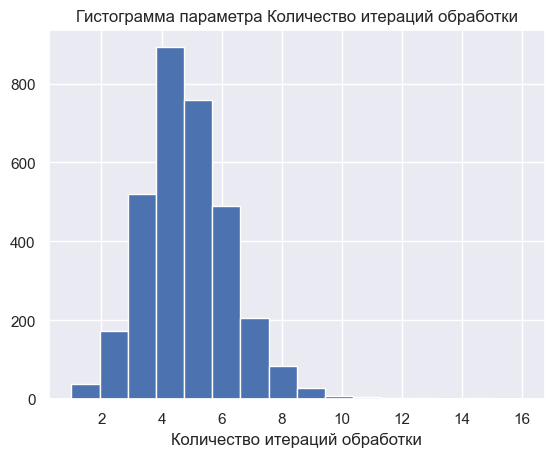

In [33]:

parameter = 'Количество итераций обработки'
df_key_counts = df[column].value_counts()
print('Частоты параметра {parameter}:')
print(df_key_counts.value_counts())
df_key_counts.hist(bins=len(df_key_counts.value_counts()));
plt.title(f'Гистограмма параметра {parameter}')
plt.xlabel(f'{parameter}')
plt.show()

Чаще всего партия обрабатывается в 4 итерации, но есть партии с от 1-й до 16-ти итераций обработки.

#### 4.1.2 Колонки `active_power` и `reactive_power`


          === Параметр 'Активная мощность' ===

Статистики признака:


count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64

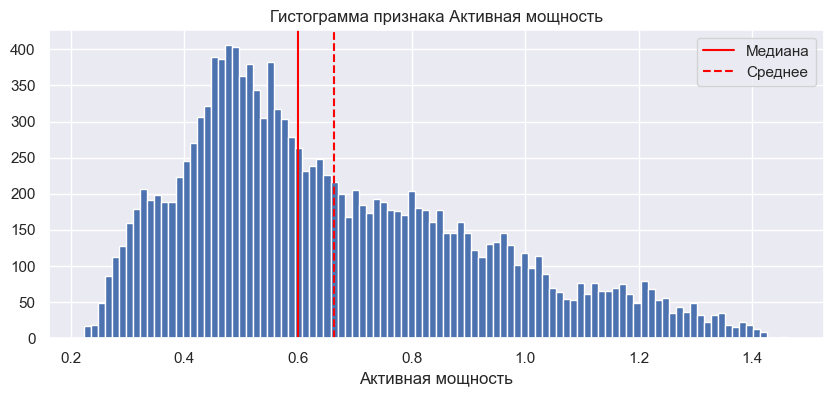

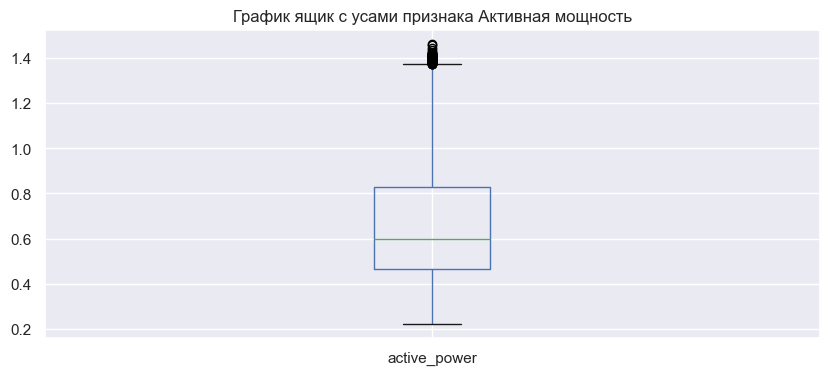

Количественный признак 'Активная мощность' принимает значения в диапазоне от 0.22312 до 1.46. Среднее значение признака 'active_power' - 0.66, медианное - 0.60. Величина стандартного отклонения: 0.26. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 4.054392259811175e-237.


In [34]:
column = 'active_power'
features = {column: 'Активная мощность'} # Значение признака
describe_feature(df, column)

Признак смещен влево, имеются выбросы справа. Явных аномалий не заметно.


          === Параметр 'Реактивная мощность' ===

Статистики признака:


count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64

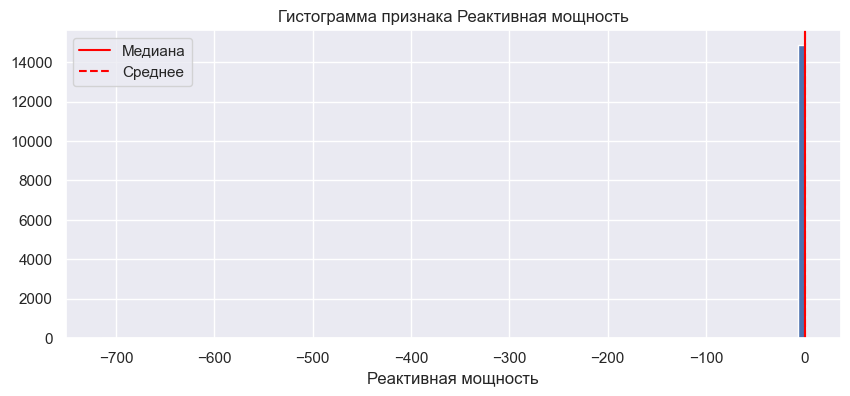

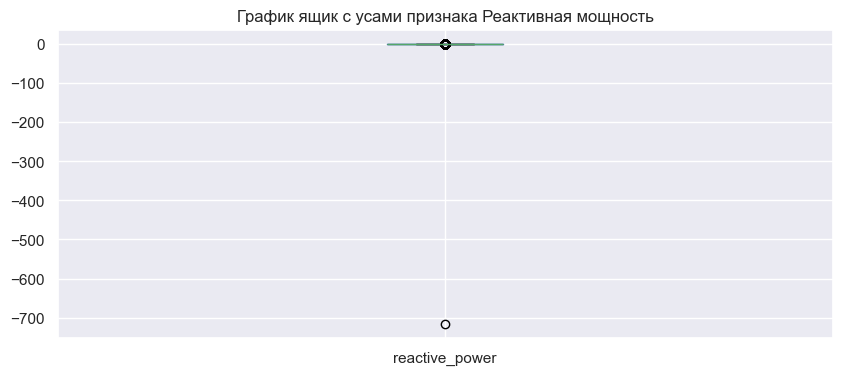

Количественный признак 'Реактивная мощность' принимает значения в диапазоне от -715.479924 до 1.27. Среднее значение признака 'reactive_power' - 0.44, медианное - 0.44. Величина стандартного отклонения: 5.87. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.


In [35]:
column = 'reactive_power'
features = {column: 'Реактивная мощность'} # Значение признака
describe_feature(df, column)

In [36]:
df[df[column] < 0.]

key           begin_heat             end_heat  active_power  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57      0.705344   

      reactive_power  
9780     -715.479924

Есть явно аномальное значение признака. Удалим данные о партии с аномальным значением.


          === Параметр 'Реактивная мощность' ===

Статистики признака:


count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64

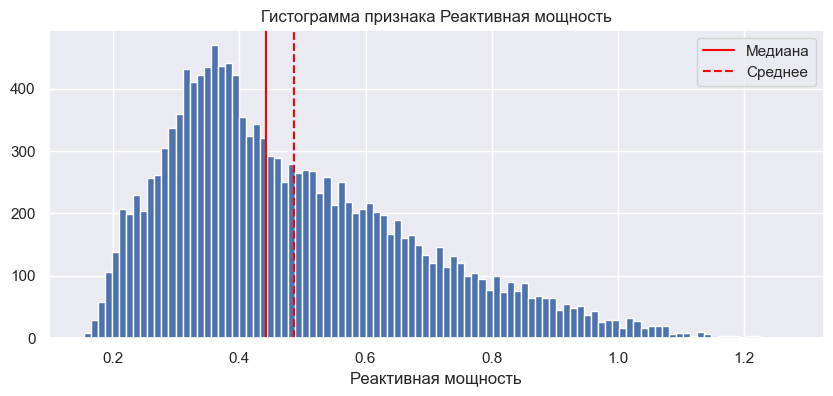

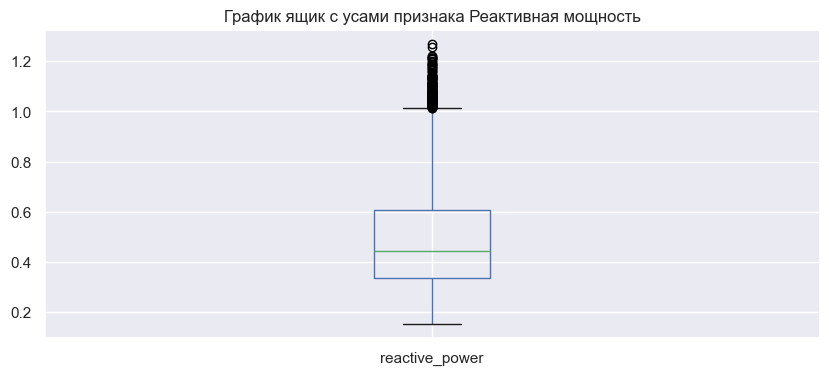

Количественный признак 'Реактивная мощность' принимает значения в диапазоне от 0.153777 до 1.27. Среднее значение признака 'reactive_power' - 0.49, медианное - 0.44. Величина стандартного отклонения: 0.20. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 6.284482773991209e-292.


In [37]:
bad_keys = df[df[column] < 0.]['key'].tolist()
df = df.query('key not in @bad_keys')
describe_feature(df, column)

Признак смещен влево, имеются выбросы справа. Явных аномалий не заметно.

#### 4.1.3 Колонки `begin_heat` и `end_heat`

Приведем данные о начале и окончании нагрева к типу `datetime` и взглянем на статистики.

In [38]:

for column in ['begin_heat', 'end_heat']:
    df[column] = pd.to_datetime(df[column])
    print(f'\nСтатистики признака {column}:')
    print(df[column].describe(datetime_is_numeric=True))


Статистики признака begin_heat:
count                            14872
mean     2019-07-05 12:17:07.251008512
min                2019-05-03 11:02:14
25%      2019-06-03 23:00:25.249999872
50%                2019-07-03 01:13:25
75%         2019-08-07 22:59:29.500000
max                2019-09-06 17:24:54
Name: begin_heat, dtype: object

Статистики признака end_heat:
count                            14872
mean     2019-07-05 12:19:58.939012864
min                2019-05-03 11:06:02
25%      2019-06-03 23:04:15.750000128
50%                2019-07-03 01:15:47
75%                2019-08-07 23:01:33
max                2019-09-06 17:26:15
Name: end_heat, dtype: object


В нашем распоряжении данные с 2019-05-03 по 2019-09-06.

#### 4.1.4 Создание признаков

Создадим синтетический признак Длительность нагрева в секундах и исследуем его.


          === Параметр 'Длительность нагрева в секундах' ===

Статистики признака:


count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: time_delta, dtype: float64

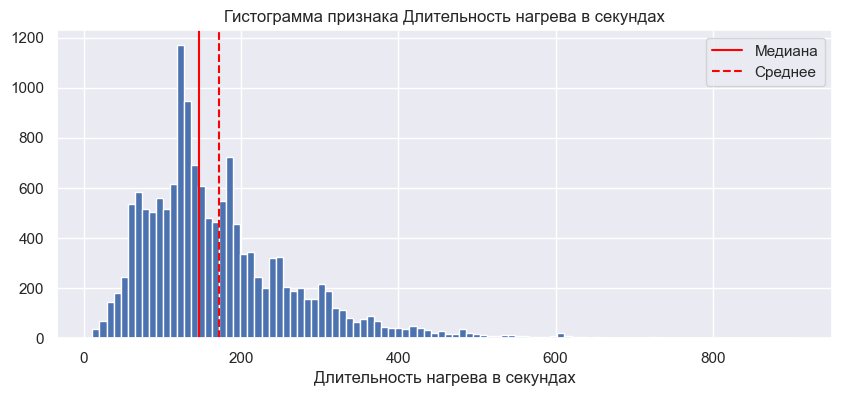

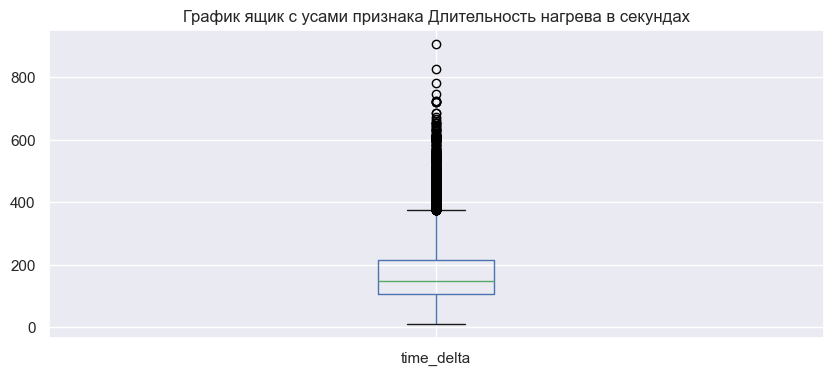

Количественный признак 'Длительность нагрева в секундах' принимает значения в диапазоне от 11.0 до 907.00. Среднее значение признака 'time_delta' - 171.69, медианное - 147.00. Величина стандартного отклонения: 98.19. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.


In [39]:

column = 'time_delta'
features = {column: 'Длительность нагрева в секундах'}
df[column] = (df['end_heat'] - df['begin_heat']).dt.total_seconds()
describe_feature(df, column)

Далее, создадим признак с номером итерации нагрева внутри каждой партии.

In [40]:
df['heat_iteration_rank'] = df.groupby('key')['begin_heat'].rank().astype(int)

Создадим признак Соотношение активной мощности к реактивной.

In [41]:
df['a_r_power_ratio'] = df['active_power'] / df['reactive_power']

Создадим признак Общая мощность (квадратный корень из суммы квадратов активной и реактивной мощностей).

In [42]:
df['power'] = np.sqrt(df['active_power']**2 + df['reactive_power']**2)

Создадим признак Энергия нагрева (активная мощность умноженная на время), дающий оценку количества энергии, переданной сырью за одну итерацию работы электродов.

In [43]:
df['active_energy'] = df['active_power'] * df['time_delta']

Создадим признак Энергия реактивная (реактивная мощность помноженная на время).

In [44]:
df['reactive_energy'] = df['reactive_power'] * df['time_delta']

Создадим признак Расход энергии (общая мощность, помноженная на время), дающий оценку потребления энергии на итерацию нагрева.

In [45]:
df['energy_spent'] = df['power'] * df['time_delta']

Кроме того, создадим признаки со значениями последней итерации в партии для всех признаков, описывающих мощность, энергию и длительность нагрева.

In [46]:
# Колонки, которые не используются для создания колонок со значением для последней итерации нагрева
excluded_columns = ['key', 'begin_heat', 'end_heat']
# Колонки со значениями для последней итерации нагрева партии
latest_value_columns = [col for col in df.columns.tolist() if col not in set(excluded_columns)]
for column in latest_value_columns:
    df['latest_' + column] = df.groupby('key')['end_heat'].transform(
                             lambda x: df.loc[x.idxmax(), column])

In [47]:
df.head().T

0                    1  \
key                                           1                    1   
begin_heat                  2019-05-03 11:02:14  2019-05-03 11:07:28   
end_heat                    2019-05-03 11:06:02  2019-05-03 11:10:33   
active_power                            0.30513             0.765658   
reactive_power                         0.211253             0.477438   
time_delta                                228.0                185.0   
heat_iteration_rank                           1                    2   
a_r_power_ratio                        1.444382              1.60368   
power                                  0.371123             0.902319   
active_energy                          69.56964            141.64673   
reactive_energy                       48.165684             88.32603   
energy_spent                          84.616003           166.928978   
latest_active_power                    0.867133             0.867133   
latest_reactive_power                  0.643691             0.643691   
latest_time_delta                         148.0                148.0   
latest_heat_iteration_rank                    5                    5   
latest_a_r_power_ratio                 1.347126             1.347126   
latest_power                           1.079934             1.079934   
latest_active_energy                 128.335684           128.335684   
latest_reactive_energy                95.266268            95.266268   
latest_energy_spent                  159.830252           159.830252   

                                              2                    3  \
key                                           1                    1   
begin_heat                  2019-05-03 11:11:44  2019-05-03 11:18:14   
end_heat                    2019-05-03 11:14:36  2019-05-03 11:24:19   
active_power                           0.580313             0.518496   
reactive_power                          0.43046             0.379979   
time_delta                                172.0                365.0   
heat_iteration_rank                           3                    4   
a_r_power_ratio                        1.348123             1.364539   
power                                  0.722536             0.642824   
active_energy                         99.813836            189.25104   
reactive_energy                        74.03912           138.692335   
energy_spent                         124.276277           234.630603   
latest_active_power                    0.867133             0.867133   
latest_reactive_power                  0.643691             0.643691   
latest_time_delta                         148.0                148.0   
latest_heat_iteration_rank                    5                    5   
latest_a_r_power_ratio                 1.347126             1.347126   
latest_power                           1.079934             1.079934   
latest_active_energy                 128.335684           128.335684   
latest_reactive_energy                95.266268            95.266268   
latest_energy_spent                  159.830252           159.830252   

                                              4  
key                                           1  
begin_heat                  2019-05-03 11:26:09  
end_heat                    2019-05-03 11:28:37  
active_power                           0.867133  
reactive_power                         0.643691  
time_delta                                148.0  
heat_iteration_rank                           5  
a_r_power_ratio                        1.347126  
power                                  1.079934  
active_energy                        128.335684  
reactive_energy                       95.266268  
energy_spent                         159.830252  
latest_active_power                    0.867133  
latest_reactive_power                  0.643691  
latest_time_delta                         148.0  
latest_heat_iteration_rank                    5  
latest_a_r_power_ratio    

#### 4.1.5 Агрегация по партиям

Агрегируем признаки по ключу. "Мощностные" признаки усредним по итерациям, "энергетические" признаки и время нагрева просуммируем. Сохраним признак количества итераций нагрева. После агрегации в колонке с данными о начале нагрева будет время начала нагрева первой итерации, в колонке с данными о завершении нагрева - время завершения нагрева последней итерации.

In [48]:
# Колонки не подлежащие агрегации
excluded_columns = ['key', 'heat_iteration_rank']
# Колонки для агрегации с использованием среднего
mean_value_columns = ['active_power', 'reactive_power', 'a_r_power_ratio', 'power']
# Колонки с константным значением в пределах одной партии
latest_value_columns = ['latest_' + col for col in latest_value_columns]
# Создание словаря с параметрами аггрегации
agg_dict = {}
# Создание словаря для переименования аггрегированных колонок
rename_dict = {}
for column in df.columns:
    if column in ['key', 'heat_iteration_rank']:
        continue
    elif column == 'begin_heat':
        agg_dict[column] = 'min'
    elif column == 'end_heat':
        agg_dict[column] = 'max'
    elif column in latest_value_columns:
        agg_dict[column] = 'last'
    elif column in mean_value_columns:
        agg_dict[column] = 'mean'
        rename_dict[column] = 'mean_' + column
    else:
        agg_dict[column] = 'sum'
        rename_dict[column] = 'total_' + column
print('Параметры агрегации:')
agg_dict

Параметры агрегации:


{'begin_heat': 'min',
 'end_heat': 'max',
 'active_power': 'mean',
 'reactive_power': 'mean',
 'time_delta': 'sum',
 'a_r_power_ratio': 'mean',
 'power': 'mean',
 'active_energy': 'sum',
 'reactive_energy': 'sum',
 'energy_spent': 'sum',
 'latest_active_power': 'last',
 'latest_reactive_power': 'last',
 'latest_time_delta': 'last',
 'latest_heat_iteration_rank': 'last',
 'latest_a_r_power_ratio': 'last',
 'latest_power': 'last',
 'latest_active_energy': 'last',
 'latest_reactive_energy': 'last',
 'latest_energy_spent': 'last'}

In [49]:
# Агрегируем колонки
df = df.groupby(by='key').agg(agg_dict)
# Переименовываем колонки
df = df.rename(columns=rename_dict)

Создадим признак с общим временем нагрева партии (от начала первой итерации до завершения последней итерации нагрева) в секундах.

In [50]:
column = 'total_heat_time'
df[column] = (df['end_heat'] - df['begin_heat']).dt.total_seconds()
# Удалим ненужные признаки
df = df.drop(columns=['begin_heat', 'end_heat'])

In [51]:
# Сохраняем обработанный датафрейм в словарь с обработанными данными
dfs_preprocessed = {table: df}
df_inf(dfs_preprocessed[table], table)


Рассмотрим датафрейм Данные об электродах.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mean_active_power           3213 non-null   float64
 1   mean_reactive_power         3213 non-null   float64
 2   total_time_delta            3213 non-null   float64
 3   mean_a_r_power_ratio        3213 non-null   float64
 4   mean_power                  3213 non-null   float64
 5   total_active_energy         3213 non-null   float64
 6   total_reactive_energy       3213 non-null   float64
 7   total_energy_spent          3213 non-null   float64
 8   latest_active_power         3213 non-null   float64
 9   latest_reactive_power       3213 non-null   float64
 10  latest_time_delta           3213 non-null   float64
 11  latest_heat_iteration_rank  3213 non-null   int32  
 12  latest_a_r_power_ratio      3213 non-null   f

key                                   1            2            3  \
mean_active_power              0.607346     0.534852     0.812728   
mean_reactive_power            0.428564     0.363339     0.587491   
total_time_delta            1098.000000   811.000000   655.000000   
mean_a_r_power_ratio           1.421570     1.479201     1.396069   
mean_power                     0.743747     0.647087     1.003845   
total_active_energy          628.616930   395.281800   581.774624   
total_reactive_energy        444.489437   274.689995   428.038924   
total_energy_spent           770.282114   481.760005   722.837668   
latest_active_power            0.867133     0.786322     0.421693   
latest_reactive_power          0.643691     0.542517     0.272562   
latest_time_delta            148.000000   210.000000    65.000000   
latest_heat_iteration_rank     5.000000     4.000000     5.000000   
latest_a_r_power_ratio         1.347126     1.449396     1.547145   
latest_power                   1.079934     0.955315     0.502111   
latest_active_energy         128.335684   165.127620    27.410045   
latest_reactive_energy        95.266268   113.928570    17.716530   
latest_energy_spent          159.830252   200.616176    32.637187   
total_heat_time             1583.000000  1144.000000  1525.000000   

key                                   4            5  
mean_active_power              0.676622     0.563238  
mean_reactive_power            0.514248     0.421998  
total_time_delta             741.000000   869.000000  
mean_a_r_power_ratio           1.307446     1.328894  
mean_power                     0.850010     0.704245  
total_active_energy          543.710274   412.180480  
total_reactive_energy        413.941977   303.070918  
total_energy_spent           683.455597   512.169934  
latest_active_power            0.864995     0.892957  
latest_reactive_power          0.654661     0.660807  
latest_time_delta            278.000000    71.000000  
latest_heat_iteration_rank     4.000000     4.000000  
latest_a_r_power_ratio         1.321287     1.351313  
latest_power                   1.084803     1.110873  
latest_active_energy         240.468610    63.399947  
latest_reactive_energy       181.995758    46.917297  
latest_energy_spent          301.575212    78.871960  
total_heat_time             1093.000000  1362.000000


В датафрейме 3213 строки и 18 столбцов. Из них 0 столбцов со строковыми значениями и 18 с числовыми.
Пропущенных значений в датафрейме нет.


### 4.2 Данные о добавлении сыпучих материалов

#### 4.2.1 Данные об объёме сыпучих материалов

In [52]:
table = 'Данные об объёме сыпучих материалов'
df_volume = dfs[table].copy()
df_inf(df_volume, table)


Рассмотрим датафрейм Данные об объёме сыпучих материалов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


0      1      2      3      4
key          1      2      3      4      5
Bulk 1     NaN    NaN    NaN    NaN    NaN
Bulk 2     NaN    NaN    NaN    NaN    NaN
Bulk 3     NaN    NaN    NaN    NaN    NaN
Bulk 4    43.0   73.0   34.0   81.0   78.0
Bulk 5    None   None   None   None   None
Bulk 6    None   None   None   None   None
Bulk 7    None   None   None   None   None
Bulk 8    None   None   None   None   None
Bulk 9    None   None   None   None   None
Bulk 10   None   None   None   None   None
Bulk 11   None   None   None   None   None
Bulk 12  206.0  206.0  205.0  207.0  203.0
Bulk 13   None   None   None   None   None
Bulk 14  150.0  149.0  152.0  153.0  151.0
Bulk 15  154.0  154.0  153.0  154.0  152.0


В датафрейме 3129 строк и 16 столбцов. Из них 11 столбец со строковыми значениями и 5 с числовыми.
15 столбцов ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0    Bulk 1                  2877        0.919463
1    Bulk 2                  3107        0.992969
2    Bulk 3                  1831        0.585171
3    Bulk 4                  2115        0.675935
4    Bulk 5                  3052        0.975391
5    Bulk 6                  2553        0.815916
6    Bulk 7                  3104        0.992010
7    Bulk 8                  3128        0.999680
8    Bulk 9                  3110        0.993928
9   Bulk 10                  2953        0.943752
10  Bulk 11                  2952        0.943432
11  Bulk 12                   679        0.217002
12  Bulk 13                  3111        0.994247
13  Bulk 14                   323        0.103228
14  Bulk 15                   881        0.281560

Приведем значения к числовому типу данных и выведем обновленную общую информацию о таблице. Названия колонок приведем к "змеиной" нотации. `key` сделаем индексом.

In [53]:
df_volume = df_volume.set_index('key')
df_volume = df_volume.apply(pd.to_numeric, errors='coerce')
df_volume.columns = [col.lower().replace(' ', '_') for col in df_volume.columns]
df_inf(df_volume, table)


Рассмотрим датафрейм Данные об объёме сыпучих материалов.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   252 non-null    float64
 1   bulk_2   22 non-null     float64
 2   bulk_3   1298 non-null   float64
 3   bulk_4   1014 non-null   float64
 4   bulk_5   77 non-null     float64
 5   bulk_6   576 non-null    float64
 6   bulk_7   25 non-null     float64
 7   bulk_8   1 non-null      float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


key          1      2      3      4      5
bulk_1     NaN    NaN    NaN    NaN    NaN
bulk_2     NaN    NaN    NaN    NaN    NaN
bulk_3     NaN    NaN    NaN    NaN    NaN
bulk_4    43.0   73.0   34.0   81.0   78.0
bulk_5     NaN    NaN    NaN    NaN    NaN
bulk_6     NaN    NaN    NaN    NaN    NaN
bulk_7     NaN    NaN    NaN    NaN    NaN
bulk_8     NaN    NaN    NaN    NaN    NaN
bulk_9     NaN    NaN    NaN    NaN    NaN
bulk_10    NaN    NaN    NaN    NaN    NaN
bulk_11    NaN    NaN    NaN    NaN    NaN
bulk_12  206.0  206.0  205.0  207.0  203.0
bulk_13    NaN    NaN    NaN    NaN    NaN
bulk_14  150.0  149.0  152.0  153.0  151.0
bulk_15  154.0  154.0  153.0  154.0  152.0


В датафрейме 3129 строк и 15 столбцов. Из них 0 столбцов со строковыми значениями и 15 с числовыми.
15 столбцов ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0    bulk_1                  2877        0.919463
1    bulk_2                  3107        0.992969
2    bulk_3                  1831        0.585171
3    bulk_4                  2115        0.675935
4    bulk_5                  3052        0.975391
5    bulk_6                  2553        0.815916
6    bulk_7                  3104        0.992010
7    bulk_8                  3128        0.999680
8    bulk_9                  3110        0.993928
9   bulk_10                  2953        0.943752
10  bulk_11                  2952        0.943432
11  bulk_12                   679        0.217002
12  bulk_13                  3111        0.994247
13  bulk_14                   323        0.103228
14  bulk_15                   881        0.281560

Для каждой партии сырья есть данные о нескольких (до 15-ти) итерациях добавления сыпучих материалов. Судя по всему, пропущенные значения означают, что в соответствующих партиях итераций добавления было меньше 15-ти. Будет разумно заменить пропуски на нулевые значения.

In [54]:
df_volume = df_volume.fillna(0.)

#### 4.2.2 Данные о времени подачи сыпучих материалов

In [55]:
table = 'Данные о времени подачи сыпучих материалов'
df_time = dfs[table].copy()
df_inf(df_time, table)


Рассмотрим датафрейм Данные о времени подачи сыпучих материалов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


0                    1                    2  \
key                        1                    2                    3   
Bulk 1                  None                 None                 None   
Bulk 2                  None                 None                 None   
Bulk 3                  None                 None                 None   
Bulk 4   2019-05-03 11:28:48  2019-05-03 11:36:50  2019-05-03 12:32:39   
Bulk 5                  None                 None                 None   
Bulk 6                  None                 None                 None   
Bulk 7                  None                 None                 None   
Bulk 8                  None                 None                 None   
Bulk 9                  None                 None                 None   
Bulk 10                 None                 None                 None   
Bulk 11                 None                 None                 None   
Bulk 12  2019-05-03 11:24:31  2019-05-03 11:53:30  2019-05-03 12:27:13   
Bulk 13                 None                 None                 None   
Bulk 14  2019-05-03 11:14:50  2019-05-03 11:48:37  2019-05-03 12:21:01   
Bulk 15  2019-05-03 11:10:43  2019-05-03 11:44:39  2019-05-03 12:16:16   

                           3                    4  
key                        4                    5  
Bulk 1                  None                 None  
Bulk 2                  None                 None  
Bulk 3                  None                 None  
Bulk 4   2019-05-03 12:43:22  2019-05-03 13:30:47  
Bulk 5                  None                 None  
Bulk 6                  None                 None  
Bulk 7                  None                 None  
Bulk 8                  None                 None  
Bulk 9                  None                 None  
Bulk 10                 None                 None  
Bulk 11                 None                 None  
Bulk 12  2019-05-03 12:58:00  2019-05-03 13:30:47  
Bulk 13                 None                 None  
Bulk 14  2019-05-03 12:51:11  2019-05-03 13:34:12  
Bulk 15  2019-05-03 12:46:36  2019-05-03 13:30:47


В датафрейме 3129 строк и 16 столбцов. Из них 15 столбцов со строковыми значениями и 1 с числовыми.
15 столбцов ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0    Bulk 1                  2877        0.919463
1    Bulk 2                  3107        0.992969
2    Bulk 3                  1831        0.585171
3    Bulk 4                  2115        0.675935
4    Bulk 5                  3052        0.975391
5    Bulk 6                  2553        0.815916
6    Bulk 7                  3104        0.992010
7    Bulk 8                  3128        0.999680
8    Bulk 9                  3110        0.993928
9   Bulk 10                  2953        0.943752
10  Bulk 11                  2952        0.943432
11  Bulk 12                   679        0.217002
12  Bulk 13                  3111        0.994247
13  Bulk 14                   323        0.103228
14  Bulk 15                   881        0.281560

Приведем значения к типу данных `datetime` и выведем обновленную общую информацию о таблице. Названия колонок приведем к "змеиной" нотации. `key` сделаем индексом.

In [56]:
df_time = df_time.set_index('key')
for col in df_time.columns:
    df_time[col] = pd.to_datetime(df_time[col])
df_time.columns = [col.lower().replace(' ', '_') for col in df_time.columns]
df_inf(df_time, table, print_text=False)


Рассмотрим датафрейм Данные о времени подачи сыпучих материалов.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   bulk_1   252 non-null    datetime64[ns]
 1   bulk_2   22 non-null     datetime64[ns]
 2   bulk_3   1298 non-null   datetime64[ns]
 3   bulk_4   1014 non-null   datetime64[ns]
 4   bulk_5   77 non-null     datetime64[ns]
 5   bulk_6   576 non-null    datetime64[ns]
 6   bulk_7   25 non-null     datetime64[ns]
 7   bulk_8   1 non-null      datetime64[ns]
 8   bulk_9   19 non-null     datetime64[ns]
 9   bulk_10  176 non-null    datetime64[ns]
 10  bulk_11  177 non-null    datetime64[ns]
 11  bulk_12  2450 non-null   datetime64[ns]
 12  bulk_13  18 non-null     datetime64[ns]
 13  bulk_14  2806 non-null   datetime64[ns]
 14  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


key                       1                   2                   3  \
bulk_1                  NaT                 NaT                 NaT   
bulk_2                  NaT                 NaT                 NaT   
bulk_3                  NaT                 NaT                 NaT   
bulk_4  2019-05-03 11:28:48 2019-05-03 11:36:50 2019-05-03 12:32:39   
bulk_5                  NaT                 NaT                 NaT   
bulk_6                  NaT                 NaT                 NaT   
bulk_7                  NaT                 NaT                 NaT   
bulk_8                  NaT                 NaT                 NaT   
bulk_9                  NaT                 NaT                 NaT   
bulk_10                 NaT                 NaT                 NaT   
bulk_11                 NaT                 NaT                 NaT   
bulk_12 2019-05-03 11:24:31 2019-05-03 11:53:30 2019-05-03 12:27:13   
bulk_13                 NaT                 NaT                 NaT   
bulk_14 2019-05-03 11:14:50 2019-05-03 11:48:37 2019-05-03 12:21:01   
bulk_15 2019-05-03 11:10:43 2019-05-03 11:44:39 2019-05-03 12:16:16   

key                       4                   5  
bulk_1                  NaT                 NaT  
bulk_2                  NaT                 NaT  
bulk_3                  NaT                 NaT  
bulk_4  2019-05-03 12:43:22 2019-05-03 13:30:47  
bulk_5                  NaT                 NaT  
bulk_6                  NaT                 NaT  
bulk_7                  NaT                 NaT  
bulk_8                  NaT                 NaT  
bulk_9                  NaT                 NaT  
bulk_10                 NaT                 NaT  
bulk_11                 NaT                 NaT  
bulk_12 2019-05-03 12:58:00 2019-05-03 13:30:47  
bulk_13                 NaT                 NaT  
bulk_14 2019-05-03 12:51:11 2019-05-03 13:34:12  
bulk_15 2019-05-03 12:46:36 2019-05-03 13:30:47

15 столбцов ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0    bulk_1                  2877        0.919463
1    bulk_2                  3107        0.992969
2    bulk_3                  1831        0.585171
3    bulk_4                  2115        0.675935
4    bulk_5                  3052        0.975391
5    bulk_6                  2553        0.815916
6    bulk_7                  3104        0.992010
7    bulk_8                  3128        0.999680
8    bulk_9                  3110        0.993928
9   bulk_10                  2953        0.943752
10  bulk_11                  2952        0.943432
11  bulk_12                   679        0.217002
12  bulk_13                  3111        0.994247
13  bulk_14                   323        0.103228
14  bulk_15                   881        0.281560

#### 4.2.3 Создание признаков

Создадим признак `total_bulk_time` с общим временем добавления сыпучих материалов.

In [57]:
column = 'total_bulk_time'
df_time[column] = (df_time.max(axis = 1) - df_time.min(axis = 1)).dt.total_seconds()


          === Параметр 'Время добавления сыпучих материалов в секундах' ===

Статистики признака:


count     3129.000000
mean       964.906679
std        798.088025
min          0.000000
25%        485.000000
50%        877.000000
75%       1311.000000
max      13683.000000
Name: total_bulk_time, dtype: float64

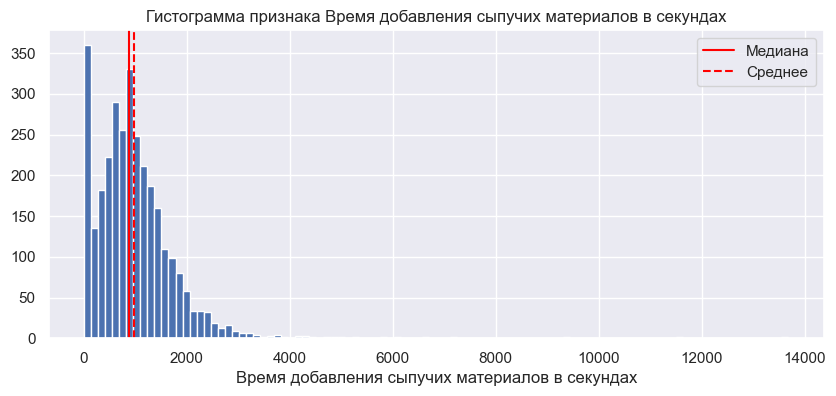

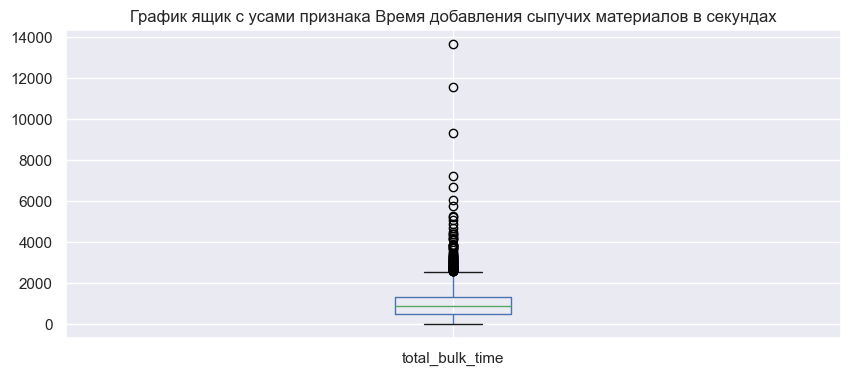

Количественный признак 'Время добавления сыпучих материалов в секундах' принимает значения в диапазоне от 0.0 до 13683.00. Среднее значение признака 'total_bulk_time' - 964.91, медианное - 877.00. Величина стандартного отклонения: 798.09. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.


In [58]:
features = {column: 'Время добавления сыпучих материалов в секундах'}
describe_feature(df_time, column)

В более чем 350-ти случаях между итерациями нет разницы во времени (возможно, была одна итерация, или о них нет данных). В ряде случаев разница составляет больше часа. Мы имеем дело с выбросами в данном признаке.

Далее, создадим признак `total_bulk` - общий объем добавленного сыпучего материала.

In [59]:
column = 'total_bulk'
df_volume[column] = df_volume.sum(axis=1)
df_volume.head().T

key             1      2      3      4      5
bulk_1        0.0    0.0    0.0    0.0    0.0
bulk_2        0.0    0.0    0.0    0.0    0.0
bulk_3        0.0    0.0    0.0    0.0    0.0
bulk_4       43.0   73.0   34.0   81.0   78.0
bulk_5        0.0    0.0    0.0    0.0    0.0
bulk_6        0.0    0.0    0.0    0.0    0.0
bulk_7        0.0    0.0    0.0    0.0    0.0
bulk_8        0.0    0.0    0.0    0.0    0.0
bulk_9        0.0    0.0    0.0    0.0    0.0
bulk_10       0.0    0.0    0.0    0.0    0.0
bulk_11       0.0    0.0    0.0    0.0    0.0
bulk_12     206.0  206.0  205.0  207.0  203.0
bulk_13       0.0    0.0    0.0    0.0    0.0
bulk_14     150.0  149.0  152.0  153.0  151.0
bulk_15     154.0  154.0  153.0  154.0  152.0
total_bulk  553.0  582.0  544.0  595.0  584.0


          === Параметр 'Объем добавленного сыпучего материала' ===

Статистики признака:


count    3129.000000
mean      595.503356
std       276.557794
min        19.000000
25%       429.000000
50%       591.000000
75%       772.000000
max      3235.000000
Name: total_bulk, dtype: float64

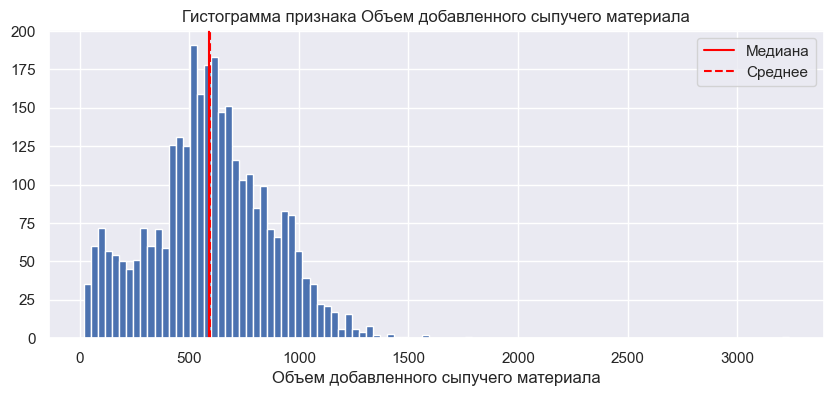

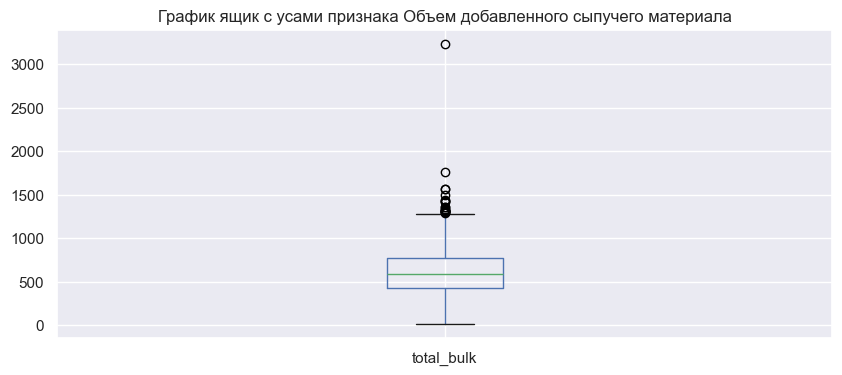

Количественный признак 'Объем добавленного сыпучего материала' принимает значения в диапазоне от 19.0 до 3235.00. Среднее значение признака 'total_bulk' - 595.50, медианное - 591.00. Величина стандартного отклонения: 276.56. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 7.469074044331187e-53.


In [60]:
features = {column: 'Объем добавленного сыпучего материала'}
describe_feature(df_volume, column)

В признаке наличествуют выбросы.

Сохраним датафреймы с созданными признаками.

In [61]:
dfs_preprocessed['Данные об объёме сыпучих материалов'] = df_volume[['total_bulk']]
dfs_preprocessed['Данные о времени подачи сыпучих материалов'] = df_time[['total_bulk_time']]

### 4.3 Данные о продувке сплава газом

In [62]:
table = 'Данные о продувке сплава газом'
df = dfs[table].copy()
df_inf(df, table)


Рассмотрим датафрейм Данные о продувке сплава газом.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


0          1          2          3         4
key     1.000000   2.000000   3.000000   4.000000  5.000000
Газ 1  29.749986  12.555561  28.554793  18.841219  5.413692


В датафрейме 3239 строк и 2 столбца. Из них 0 столбцов со строковыми значениями и 2 с числовыми.
Пропущенных значений в датафрейме нет.


Приведем значения `key` к целочисленному типу данных и выведем обновленную общую информацию о таблице. Названия колонок приведем к "змеиной" нотации. `key` сделаем индексом.

In [63]:
df['key'] = df['key'].astype(int)
df.columns = [col.replace('Газ 1', 'gas') for col in df.columns]
df = df.set_index('key')
df_inf(df, table)


Рассмотрим датафрейм Данные о продувке сплава газом.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas     3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


key          1          2          3          4         5
gas  29.749986  12.555561  28.554793  18.841219  5.413692


В датафрейме 3239 строк и 1 столбец. Из них 0 столбцов со строковыми значениями и 1 с числовыми.
Пропущенных значений в датафрейме нет.


Сохраним обработанный датафрейм.

In [64]:
dfs_preprocessed[table] = df

### 4.4 Данные об измерениях температуры

In [65]:
table = 'Данные об измерениях температуры'
df = dfs[table].copy()
df_inf(df, table)


Рассмотрим датафрейм Данные об измерениях температуры.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


0                    1                    2  \
key                             1                    1                    1   
Время замера  2019-05-03 11:02:04  2019-05-03 11:07:18  2019-05-03 11:11:34   
Температура                1571.0               1604.0               1618.0   

                                3                    4  
key                             1                    1  
Время замера  2019-05-03 11:18:04  2019-05-03 11:25:59  
Температура                1601.0               1606.0


В датафрейме 18092 строки и 3 столбца. Из них 2 столбца со строковыми значениями и 1 с числовыми.
1 столбец ['Температура'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0  Температура                  3427        0.189421

Названия колонок приведем к "змеиной" нотации. Приведем значения времени замера к типу данных `datetime`, значения температуры - к `float`.

In [66]:
df.columns = ['key', 'measurement_time', 'temperature']
df['measurement_time'] = pd.to_datetime(df['measurement_time'])
df['temperature'] = df['temperature'].astype(float)

Мы можем использовать только начальную (как входной признак) и конечную (как целевой признак) температуры партии, использование промежуточных значений приведет к утечке данных. Отсюда следует следующий план обработки данных о температуре. Находим первое и последнее измерение для каждой партии, остальные измерения отбрасываем. Затем удаляем измерения с пропущенными значениями и обрабатываем аномалии в данных. Далее, удаляем информацию о партиях с недостаточной информацией (менее двух измерений). Такой порядок защитит от утечек данных (мы не примем начальное или промежуточное измерение за целевой признак, кроме того, мы не примем промежуточное измерение за начальное).

Создадим колонки со временем первого и последнего измерения для каждой партии.

In [67]:
last_measurement_time_dict = df.groupby(by='key')['measurement_time'].max().to_dict()
df['last_measurement_time'] = df['key'].apply(lambda x: last_measurement_time_dict[x])
first_measurement_time_dict = df.groupby(by='key')['measurement_time'].min().to_dict()
df['first_measurement_time'] = df['key'].apply(lambda x: first_measurement_time_dict[x])

Отбросим все измерения, кроме первого и последнего для каждой партии.

In [68]:
df = df.query('measurement_time==last_measurement_time or measurement_time==first_measurement_time')
df_inf(df, table)


Рассмотрим датафрейм Данные об измерениях температуры.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6430 entries, 0 to 18091
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     6430 non-null   int64         
 1   measurement_time        6430 non-null   datetime64[ns]
 2   temperature             5691 non-null   float64       
 3   last_measurement_time   6430 non-null   datetime64[ns]
 4   first_measurement_time  6430 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 301.4 KB


0                    5   \
key                                       1                    1   
measurement_time        2019-05-03 11:02:04  2019-05-03 11:30:38   
temperature                          1571.0               1613.0   
last_measurement_time   2019-05-03 11:30:38  2019-05-03 11:30:38   
first_measurement_time  2019-05-03 11:02:04  2019-05-03 11:02:04   

                                         6                    10  \
key                                       2                    2   
measurement_time        2019-05-03 11:34:04  2019-05-03 11:55:09   
temperature                          1581.0               1602.0   
last_measurement_time   2019-05-03 11:55:09  2019-05-03 11:55:09   
first_measurement_time  2019-05-03 11:34:04  2019-05-03 11:34:04   

                                         11  
key                                       3  
measurement_time        2019-05-03 12:06:44  
temperature                          1596.0  
last_measurement_time   2019-05-03 12:35:57  
first_measurement_time  2019-05-03 12:06:44


В датафрейме 6430 строк и 5 столбцов. Из них 0 столбцов со строковыми значениями и 5 с числовыми.
1 столбец ['temperature'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0  temperature                   739         0.11493

Удалим пропущенные значения.

In [69]:
df = df.dropna()

Взглянем на распределение температуры.


          === Параметр 'Температура' ===

Статистики признака:


count    5691.000000
mean     1591.525040
std        24.546141
min      1191.000000
25%      1580.000000
50%      1591.000000
75%      1602.000000
max      1700.000000
Name: temperature, dtype: float64

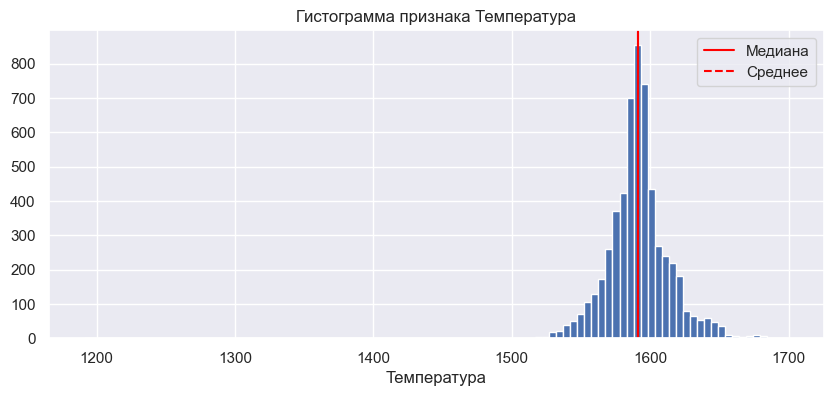

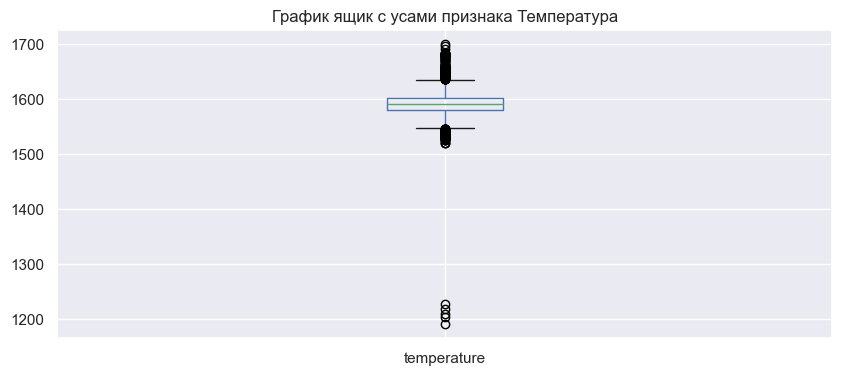

Количественный признак 'Температура' принимает значения в диапазоне от 1191.0 до 1700.00. Среднее значение признака 'temperature' - 1591.53, медианное - 1591.00. Величина стандартного отклонения: 24.55. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.


In [70]:
column = 'temperature'
features = {column: 'Температура'}
describe_feature(df, column)

Значения температуры ниже 1500 градусов считаются аномальными, примем эти значения равными 1500.

In [71]:
df.loc[df['temperature'] <= 1500, 'temperature'] = 1500.


          === Параметр 'Температура' ===

Статистики признака:


count    5691.000000
mean     1591.780179
std        21.943072
min      1500.000000
25%      1580.000000
50%      1591.000000
75%      1602.000000
max      1700.000000
Name: temperature, dtype: float64

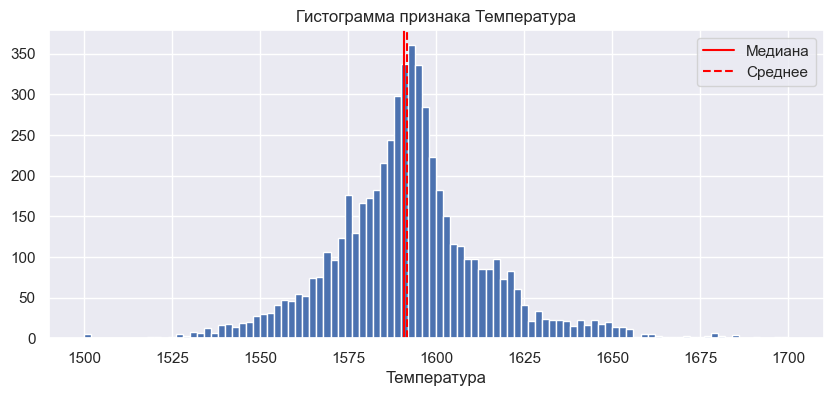

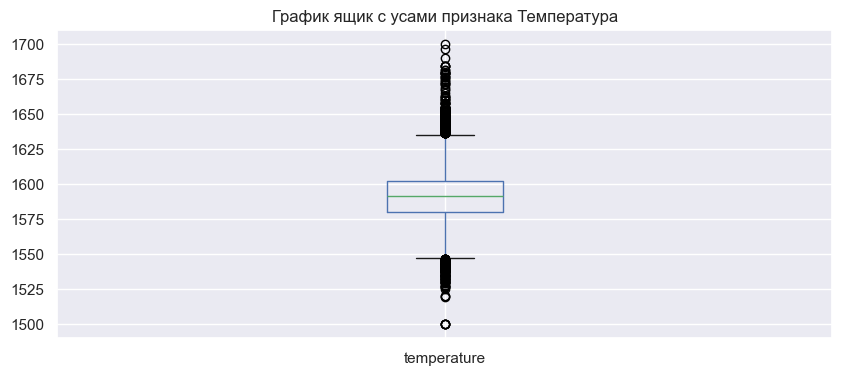

Количественный признак 'Температура' принимает значения в диапазоне от 1500.0 до 1700.00. Среднее значение признака 'temperature' - 1591.78, медианное - 1591.00. Величина стандартного отклонения: 21.94. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 6.241542858757024e-78.


In [72]:
describe_feature(df, column)

Удалим информацию о партиях, для которых есть только одно измерение.

In [73]:
# Находим ключи для которых количество измерений недостаточно
key_count = df['key'].value_counts()
bad_keys = key_count[key_count < 2].index
# Удаляем информацию с найденными ключами
df = df.query('key not in @bad_keys')
df_inf(df, table)


Рассмотрим датафрейм Данные об измерениях температуры.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4950 entries, 0 to 13925
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     4950 non-null   int64         
 1   measurement_time        4950 non-null   datetime64[ns]
 2   temperature             4950 non-null   float64       
 3   last_measurement_time   4950 non-null   datetime64[ns]
 4   first_measurement_time  4950 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 232.0 KB


0                    5   \
key                                       1                    1   
measurement_time        2019-05-03 11:02:04  2019-05-03 11:30:38   
temperature                          1571.0               1613.0   
last_measurement_time   2019-05-03 11:30:38  2019-05-03 11:30:38   
first_measurement_time  2019-05-03 11:02:04  2019-05-03 11:02:04   

                                         6                    10  \
key                                       2                    2   
measurement_time        2019-05-03 11:34:04  2019-05-03 11:55:09   
temperature                          1581.0               1602.0   
last_measurement_time   2019-05-03 11:55:09  2019-05-03 11:55:09   
first_measurement_time  2019-05-03 11:34:04  2019-05-03 11:34:04   

                                         11  
key                                       3  
measurement_time        2019-05-03 12:06:44  
temperature                          1596.0  
last_measurement_time   2019-05-03 12:35:57  
first_measurement_time  2019-05-03 12:06:44


В датафрейме 4950 строк и 5 столбцов. Из них 0 столбцов со строковыми значениями и 5 с числовыми.
Пропущенных значений в датафрейме нет.


Сгруппируем данные по ключу и создадим целевой признак (последняя температура партии) и признак с начальной температурой.

In [74]:
df = df.groupby('key').apply(
    lambda group: pd.Series({
        'target': group.loc[group['measurement_time'].idxmax(), 'temperature'],
        'init_temp': group.loc[group['measurement_time'].idxmin(), 'temperature']
    })
)
df_inf(df, table)


Рассмотрим датафрейм Данные об измерениях температуры.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   target     2475 non-null   float64
 1   init_temp  2475 non-null   float64
dtypes: float64(2)
memory usage: 58.0 KB


key             1       2       3       4       5
target     1613.0  1602.0  1599.0  1625.0  1602.0
init_temp  1571.0  1581.0  1596.0  1601.0  1576.0


В датафрейме 2475 строк и 2 столбца. Из них 0 столбцов со строковыми значениями и 2 с числовыми.
Пропущенных значений в датафрейме нет.


Сохраним обработанный датафрейм.

In [75]:
dfs_preprocessed[table] = df

### 4.5 Данные о добавлении проволочных материалов

#### 4.5.1 Данные об объёме проволочных материалов

In [76]:
table = 'Данные об объёме проволочных материалов'
df_volume = dfs[table].copy()
df_inf(df_volume, table)


Рассмотрим датафрейм Данные об объёме проволочных материалов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


0          1          2          3          4
key             1          2          3          4          5
Wire 1  60.059998  96.052315  91.160157  89.063515  89.238236
Wire 2       None       None       None       None    9.11456
Wire 3       None       None       None       None       None
Wire 4       None       None       None       None       None
Wire 5       None       None       None       None       None
Wire 6       None       None       None       None       None
Wire 7       None       None       None       None       None
Wire 8       None       None       None       None       None
Wire 9       None       None       None       None       None


В датафрейме 3081 строка и 10 столбцов. Из них 8 столбцов со строковыми значениями и 2 с числовыми.
9 столбцов ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0  Wire 1                    26        0.008439
1  Wire 2                  2002        0.649789
2  Wire 3                  3018        0.979552
3  Wire 4                  3067        0.995456
4  Wire 5                  3080        0.999675
5  Wire 6                  3008        0.976306
6  Wire 7                  3070        0.996430
7  Wire 8                  3062        0.993833
8  Wire 9                  3052        0.990587

Приведем значения к числовому типу данных и выведем обновленную общую информацию о таблице. Названия колонок приведем к "змеиной" нотации. `key` сделаем индексом.

In [77]:
df_volume = df_volume.set_index('key')
df_volume = df_volume.apply(pd.to_numeric, errors='coerce')
df_volume.columns = [col.lower().replace(' ', '_') for col in df_volume.columns]
df_inf(df_volume, table)


Рассмотрим датафрейм Данные об объёме проволочных материалов.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3055 non-null   float64
 1   wire_2  1079 non-null   float64
 2   wire_3  63 non-null     float64
 3   wire_4  14 non-null     float64
 4   wire_5  1 non-null      float64
 5   wire_6  73 non-null     float64
 6   wire_7  11 non-null     float64
 7   wire_8  19 non-null     float64
 8   wire_9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


key             1          2          3          4          5
wire_1  60.059998  96.052315  91.160157  89.063515  89.238236
wire_2        NaN        NaN        NaN        NaN   9.114560
wire_3        NaN        NaN        NaN        NaN        NaN
wire_4        NaN        NaN        NaN        NaN        NaN
wire_5        NaN        NaN        NaN        NaN        NaN
wire_6        NaN        NaN        NaN        NaN        NaN
wire_7        NaN        NaN        NaN        NaN        NaN
wire_8        NaN        NaN        NaN        NaN        NaN
wire_9        NaN        NaN        NaN        NaN        NaN


В датафрейме 3081 строка и 9 столбцов. Из них 0 столбцов со строковыми значениями и 9 с числовыми.
9 столбцов ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0  wire_1                    26        0.008439
1  wire_2                  2002        0.649789
2  wire_3                  3018        0.979552
3  wire_4                  3067        0.995456
4  wire_5                  3080        0.999675
5  wire_6                  3008        0.976306
6  wire_7                  3070        0.996430
7  wire_8                  3062        0.993833
8  wire_9                  3052        0.990587

Для каждой партии сырья есть данные о нескольких (до 9-ти) итерациях добавления проволочных материалов. Судя по всему, пропущенные значения означают, что в соответствующих партиях итераций добавлений было меньше 9-ти. Будет разумно заменить пропуски на нулевые значения.

In [78]:
df_volume = df_volume.fillna(0.)

#### 4.5.2 Данные о времени подачи проволочных материалов

In [79]:
table = 'Данные о времени подачи проволочных материалов'
df_time = dfs[table]
df_inf(df_time, table)


Рассмотрим датафрейм Данные о времени подачи проволочных материалов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


0                    1                    2  \
key                       1                    2                    3   
Wire 1  2019-05-03 11:06:19  2019-05-03 11:36:50  2019-05-03 12:11:46   
Wire 2                 None                 None                 None   
Wire 3                 None                 None                 None   
Wire 4                 None                 None                 None   
Wire 5                 None                 None                 None   
Wire 6                 None                 None                 None   
Wire 7                 None                 None                 None   
Wire 8                 None                 None                 None   
Wire 9                 None                 None                 None   

                          3                    4  
key                       4                    5  
Wire 1  2019-05-03 12:43:22  2019-05-03 13:20:44  
Wire 2                 None  2019-05-03 13:15:34  
Wire 3                 None                 None  
Wire 4                 None                 None  
Wire 5                 None                 None  
Wire 6                 None                 None  
Wire 7                 None                 None  
Wire 8                 None                 None  
Wire 9                 None                 None


В датафрейме 3081 строка и 10 столбцов. Из них 9 столбцов со строковыми значениями и 1 с числовыми.
9 столбцов ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0  Wire 1                    26        0.008439
1  Wire 2                  2002        0.649789
2  Wire 3                  3018        0.979552
3  Wire 4                  3067        0.995456
4  Wire 5                  3080        0.999675
5  Wire 6                  3008        0.976306
6  Wire 7                  3070        0.996430
7  Wire 8                  3062        0.993833
8  Wire 9                  3052        0.990587

Приведем значения к типу данных `datetime` и выведем обновленную общую информацию о таблице. Названия колонок приведем к "змеиной" нотации. `key` сделаем индексом.

In [80]:
df_time = df_time.set_index('key')
for col in df_time.columns:
    df_time[col] = pd.to_datetime(df_time[col])
df_time.columns = [col.lower().replace(' ', '_') for col in df_time.columns]
df_inf(df_time, table, print_text=False)


Рассмотрим датафрейм Данные о времени подачи проволочных материалов.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wire_1  3055 non-null   datetime64[ns]
 1   wire_2  1079 non-null   datetime64[ns]
 2   wire_3  63 non-null     datetime64[ns]
 3   wire_4  14 non-null     datetime64[ns]
 4   wire_5  1 non-null      datetime64[ns]
 5   wire_6  73 non-null     datetime64[ns]
 6   wire_7  11 non-null     datetime64[ns]
 7   wire_8  19 non-null     datetime64[ns]
 8   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


key                      1                   2                   3  \
wire_1 2019-05-03 11:06:19 2019-05-03 11:36:50 2019-05-03 12:11:46   
wire_2                 NaT                 NaT                 NaT   
wire_3                 NaT                 NaT                 NaT   
wire_4                 NaT                 NaT                 NaT   
wire_5                 NaT                 NaT                 NaT   
wire_6                 NaT                 NaT                 NaT   
wire_7                 NaT                 NaT                 NaT   
wire_8                 NaT                 NaT                 NaT   
wire_9                 NaT                 NaT                 NaT   

key                      4                   5  
wire_1 2019-05-03 12:43:22 2019-05-03 13:20:44  
wire_2                 NaT 2019-05-03 13:15:34  
wire_3                 NaT                 NaT  
wire_4                 NaT                 NaT  
wire_5                 NaT                 NaT  
wire_6                 NaT                 NaT  
wire_7                 NaT                 NaT  
wire_8                 NaT                 NaT  
wire_9                 NaT                 NaT

9 столбцов ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'] содержат пропущенные значения.


Столбец  Количество_пропусков  Доля_пропусков
0  wire_1                    26        0.008439
1  wire_2                  2002        0.649789
2  wire_3                  3018        0.979552
3  wire_4                  3067        0.995456
4  wire_5                  3080        0.999675
5  wire_6                  3008        0.976306
6  wire_7                  3070        0.996430
7  wire_8                  3062        0.993833
8  wire_9                  3052        0.990587

#### 4.5.3 Создание признаков

Создадим признак `total_wire_time` с общим временем добавления проволочных материалов.

In [81]:
column = 'total_wire_time'
df_time[column] = (df_time.max(axis = 1) - df_time.min(axis = 1)).dt.total_seconds()


          === Параметр 'Время добавления проволочных материалов в секундах' ===

Статистики признака:


count    3081.000000
mean      214.519312
std       396.131967
min         0.000000
25%         0.000000
50%         0.000000
75%       401.000000
max      5937.000000
Name: total_wire_time, dtype: float64

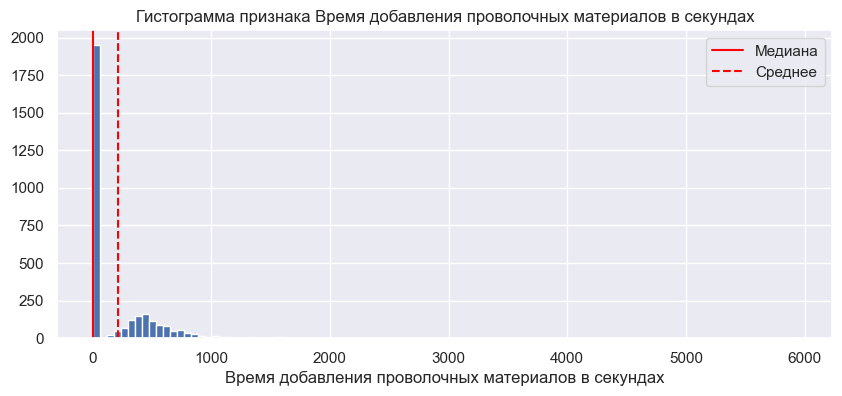

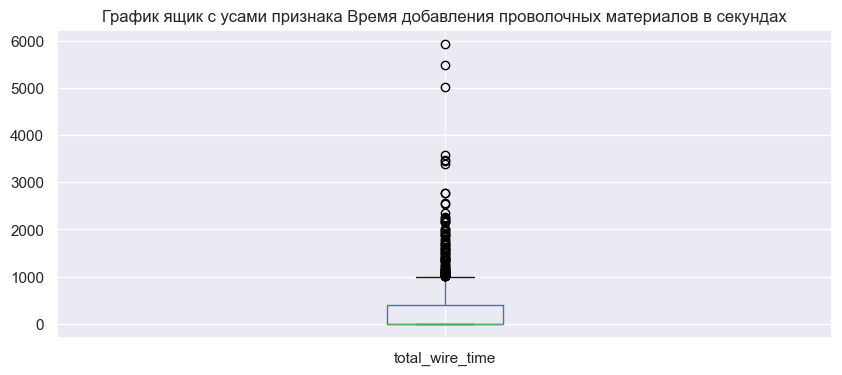

Количественный признак 'Время добавления проволочных материалов в секундах' принимает значения в диапазоне от 0.0 до 5937.00. Среднее значение признака 'total_wire_time' - 214.52, медианное - 0.00. Величина стандартного отклонения: 396.13. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.


In [82]:
features = {column: 'Время добавления проволочных материалов в секундах'}
describe_feature(df_time, column)

В более чем 1800-т случаев между итерациями нет разницы во времени (возможно, была одна итерация, или о них нет данных). В ряде случаев разница составляет больше часа. Мы имеем дело с выбросами в данном признаке.

Далее, создадим признак `total_wire` - общий объем добавленного сыпучего материала.

In [83]:
column = 'total_wire'
df_volume[column] = df_volume.sum(axis=1)
df_volume.head().T

key                 1          2          3          4          5
wire_1      60.059998  96.052315  91.160157  89.063515  89.238236
wire_2       0.000000   0.000000   0.000000   0.000000   9.114560
wire_3       0.000000   0.000000   0.000000   0.000000   0.000000
wire_4       0.000000   0.000000   0.000000   0.000000   0.000000
wire_5       0.000000   0.000000   0.000000   0.000000   0.000000
wire_6       0.000000   0.000000   0.000000   0.000000   0.000000
wire_7       0.000000   0.000000   0.000000   0.000000   0.000000
wire_8       0.000000   0.000000   0.000000   0.000000   0.000000
wire_9       0.000000   0.000000   0.000000   0.000000   0.000000
total_wire  60.059998  96.052315  91.160157  89.063515  98.352796


          === Параметр 'Объем добавленного сыпучего материала' ===

Статистики признака:


count    3081.000000
mean      123.723326
std        66.082966
min         1.918800
25%        86.112000
50%       114.179523
75%       150.181198
max       663.851766
Name: total_wire, dtype: float64

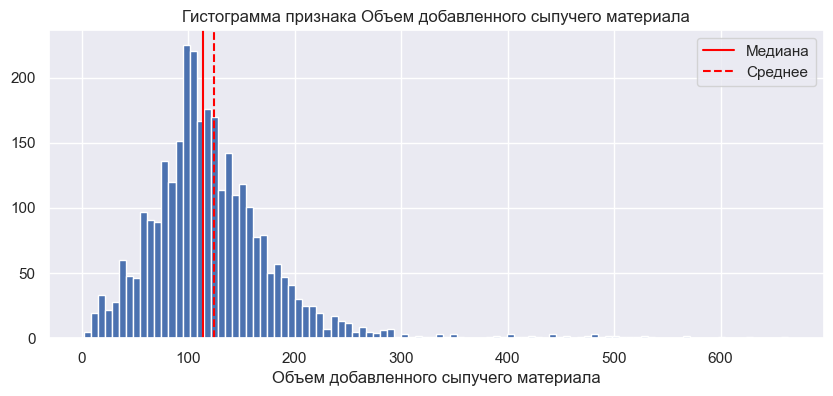

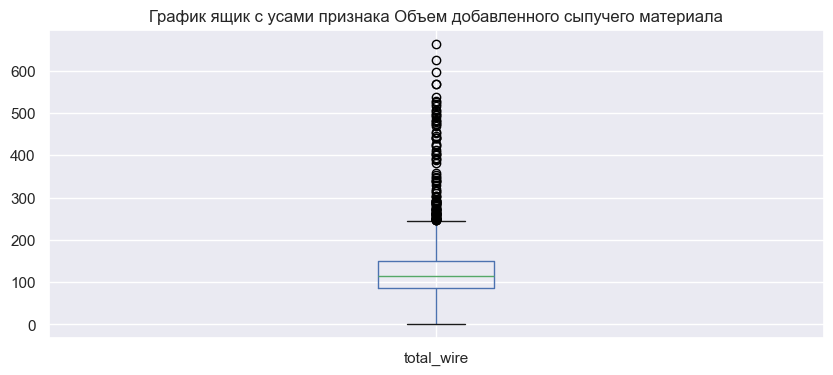

Количественный признак 'Объем добавленного сыпучего материала' принимает значения в диапазоне от 1.9188 до 663.85. Среднее значение признака 'total_wire' - 123.72, медианное - 114.18. Величина стандартного отклонения: 66.08. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.


In [84]:
features = {column: 'Объем добавленного сыпучего материала'}
describe_feature(df_volume, column)

В признаке наличествуют выбросы.

Сохраним датафреймы с созданными признаками.

In [85]:
dfs_preprocessed['Данные об объёме проаолочных материалов'] = df_volume[['total_wire']]
dfs_preprocessed['Данные о времени подачи проволочных материалов'] = df_time[['total_wire_time']]

### 4.6 Объединение данных

Объединим таблицы, поочередно присоединяя их по ключам к Данным об измерениях температуры. В итоговую таблицу войдут только те ключи, которые присутствуют во всех таблицах.

In [86]:
df = dfs_preprocessed['Данные об измерениях температуры']
for table in dfs_preprocessed.keys():
    if table == 'Данные об измерениях температуры':
        continue
    else:
        df = df.join(dfs_preprocessed[table], how='inner')
df_inf(df, 'Предобработанные данные')


Рассмотрим датафрейм Предобработанные данные.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 1 to 2499
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   target                      2328 non-null   float64
 1   init_temp                   2328 non-null   float64
 2   mean_active_power           2328 non-null   float64
 3   mean_reactive_power         2328 non-null   float64
 4   total_time_delta            2328 non-null   float64
 5   mean_a_r_power_ratio        2328 non-null   float64
 6   mean_power                  2328 non-null   float64
 7   total_active_energy         2328 non-null   float64
 8   total_reactive_energy       2328 non-null   float64
 9   total_energy_spent          2328 non-null   float64
 10  latest_active_power         2328 non-null   float64
 11  latest_reactive_power       2328 non-null   float64
 12  latest_time_delta           2328 non-null 

key                                   1            2            3  \
target                      1613.000000  1602.000000  1599.000000   
init_temp                   1571.000000  1581.000000  1596.000000   
mean_active_power              0.607346     0.534852     0.812728   
mean_reactive_power            0.428564     0.363339     0.587491   
total_time_delta            1098.000000   811.000000   655.000000   
mean_a_r_power_ratio           1.421570     1.479201     1.396069   
mean_power                     0.743747     0.647087     1.003845   
total_active_energy          628.616930   395.281800   581.774624   
total_reactive_energy        444.489437   274.689995   428.038924   
total_energy_spent           770.282114   481.760005   722.837668   
latest_active_power            0.867133     0.786322     0.421693   
latest_reactive_power          0.643691     0.542517     0.272562   
latest_time_delta            148.000000   210.000000    65.000000   
latest_heat_iteration_rank     5.000000     4.000000     5.000000   
latest_a_r_power_ratio         1.347126     1.449396     1.547145   
latest_power                   1.079934     0.955315     0.502111   
latest_active_energy         128.335684   165.127620    27.410045   
latest_reactive_energy        95.266268   113.928570    17.716530   
latest_energy_spent          159.830252   200.616176    32.637187   
total_heat_time             1583.000000  1144.000000  1525.000000   
total_bulk                   553.000000   582.000000   544.000000   
total_bulk_time             1085.000000  1000.000000   983.000000   
gas                           29.749986    12.555561    28.554793   
total_wire                    60.059998    96.052315    91.160157   
total_wire_time                0.000000     0.000000     0.000000   

key                                   4            5  
target                      1625.000000  1602.000000  
init_temp                   1601.000000  1576.000000  
mean_active_power              0.676622     0.563238  
mean_reactive_power            0.514248     0.421998  
total_time_delta             741.000000   869.000000  
mean_a_r_power_ratio           1.307446     1.328894  
mean_power                     0.850010     0.704245  
total_active_energy          543.710274   412.180480  
total_reactive_energy        413.941977   303.070918  
total_energy_spent           683.455597   512.169934  
latest_active_power            0.864995     0.892957  
latest_reactive_power          0.654661     0.660807  
latest_time_delta            278.000000    71.000000  
latest_heat_iteration_rank     4.000000     4.000000  
latest_a_r_power_ratio         1.321287     1.351313  
latest_power                   1.084803     1.110873  
latest_active_energy         240.468610    63.399947  
latest_reactive_energy       181.995758    46.917297  
latest_energy_spent          301.575212    78.871960  
total_heat_time             1093.000000  1362.000000  
total_bulk                   595.000000   584.000000  
total_bulk_time              878.000000   205.000000  
gas                           18.841219     5.413692  
total_wire                    89.063515    98.352796  
total_wire_time                0.000000   310.000000


В датафрейме 2328 строк и 25 столбцов. Из них 0 столбцов со строковыми значениями и 25 с числовыми.
Пропущенных значений в датафрейме нет.



          === Целевой признак 'target' ===

Статистики признака:


count    2328.000000
mean     1593.371993
std        11.198791
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: target, dtype: float64

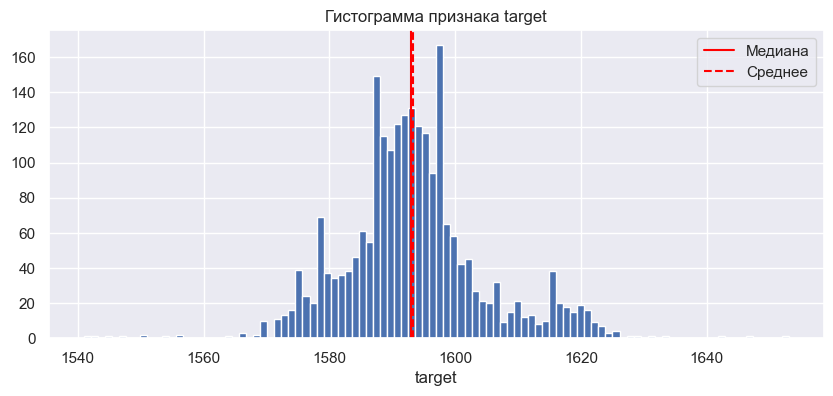

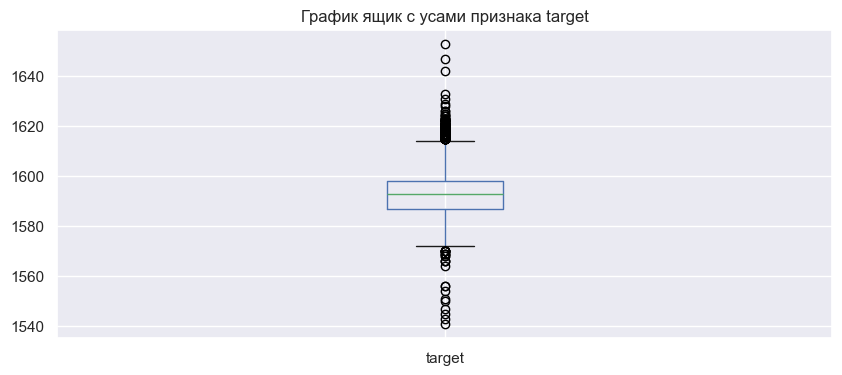

Количественный признак 'target' принимает значения в диапазоне от 1541.0 до 1653.00. Среднее значение признака 'target' - 1593.37, медианное - 1593.00. Величина стандартного отклонения: 11.20. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 7.931353232293912e-38.

          === Входной признак 'init_temp' ===

Статистики признака:


count    2328.000000
mean     1587.218643
std        23.883093
min      1500.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: init_temp, dtype: float64

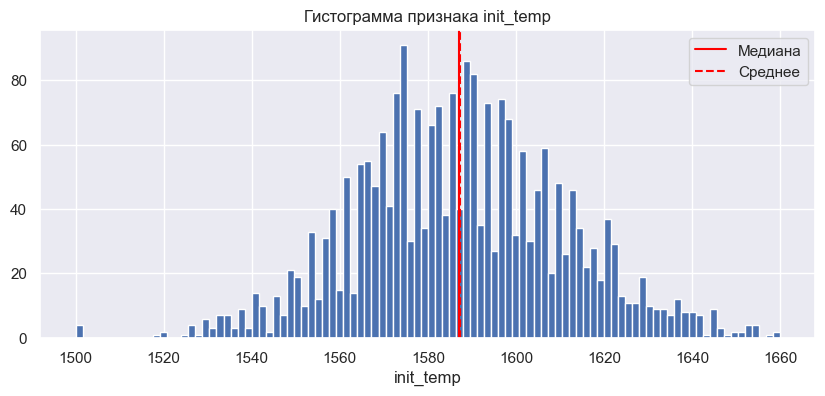

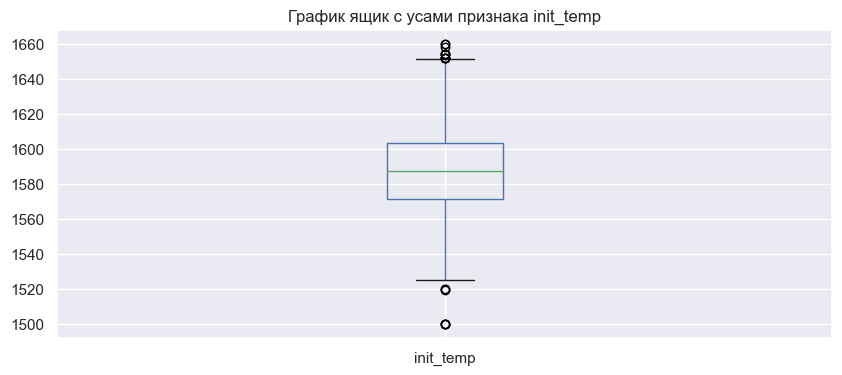

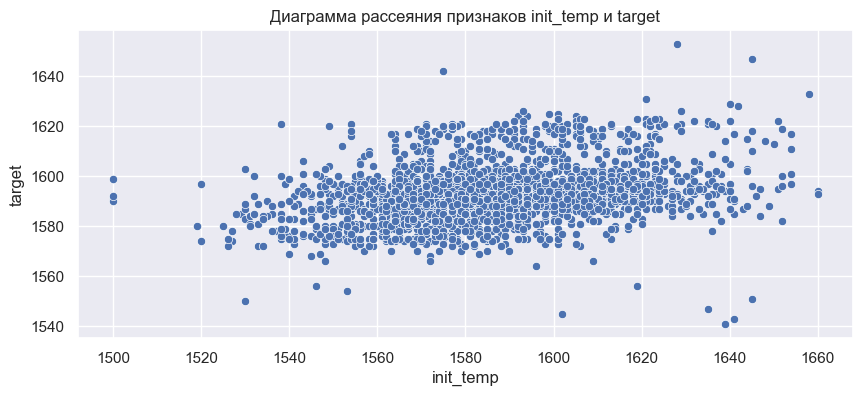

Количественный признак 'init_temp' принимает значения в диапазоне от 1500.0 до 1660.00. Среднее значение признака 'init_temp' - 1587.22, медианное - 1587.00. Величина стандартного отклонения: 23.88. По результатам теста на нормальность распределения (p-value = 0.23273887415714883) мы можем с достаточной степенью уверенности считать признак нормально распределенным. 

          === Входной признак 'mean_active_power' ===

Статистики признака:


count    2328.000000
mean        0.664104
std         0.128377
min         0.267676
25%         0.576159
50%         0.655834
75%         0.741641
max         1.243889
Name: mean_active_power, dtype: float64

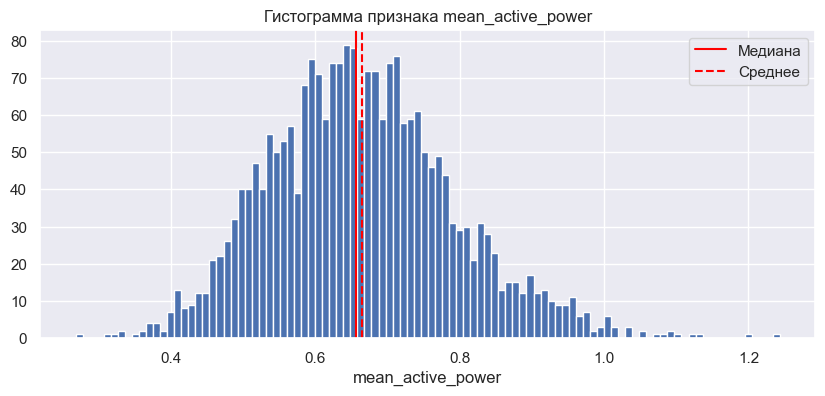

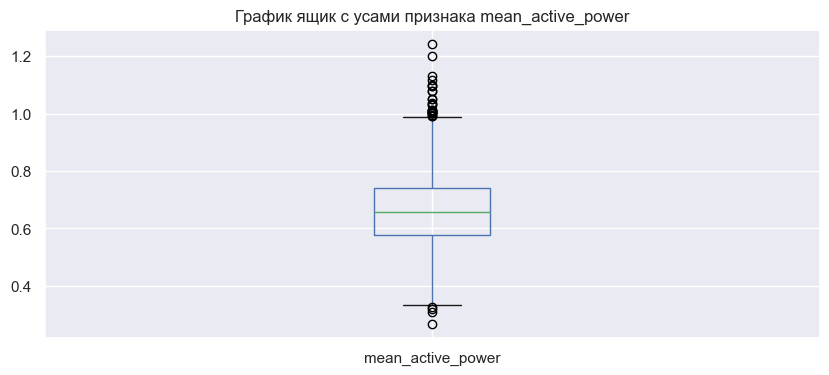

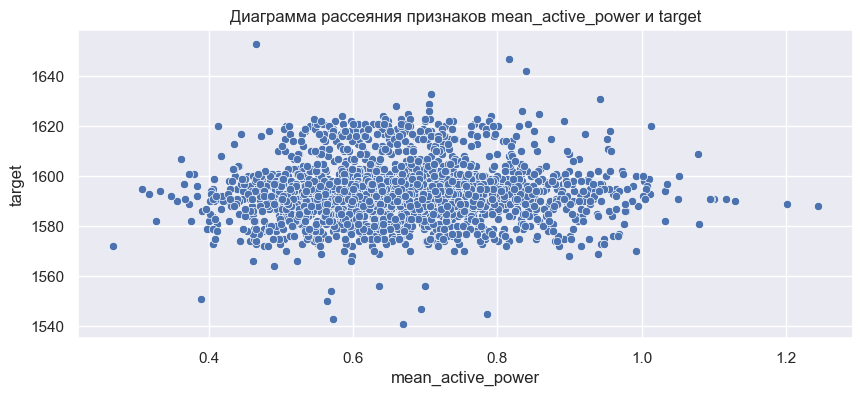

Количественный признак 'mean_active_power' принимает значения в диапазоне от 0.267676 до 1.24. Среднее значение признака 'mean_active_power' - 0.66, медианное - 0.66. Величина стандартного отклонения: 0.13. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 5.156118187180133e-15.

          === Входной признак 'mean_reactive_power' ===

Статистики признака:


count    2328.000000
mean        0.488890
std         0.097967
min         0.196228
25%         0.420039
50%         0.484669
75%         0.546539
max         0.960763
Name: mean_reactive_power, dtype: float64

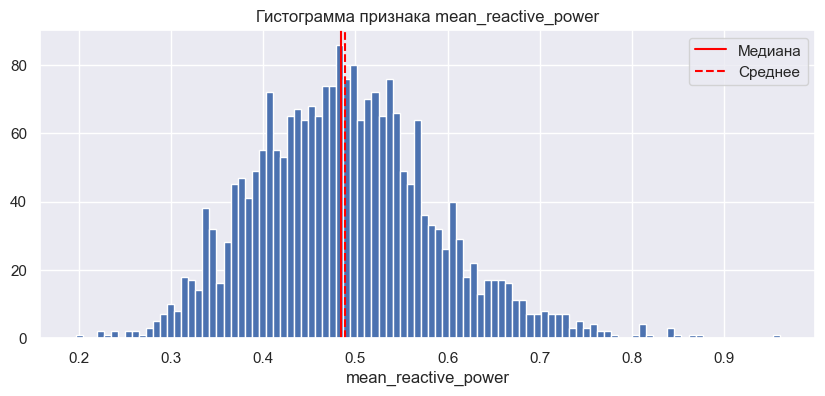

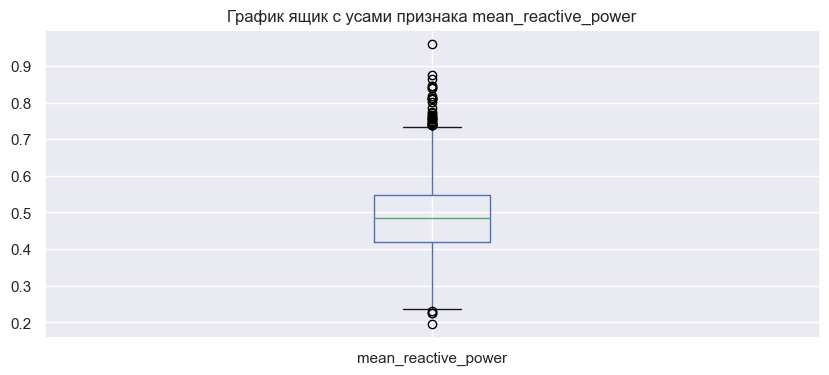

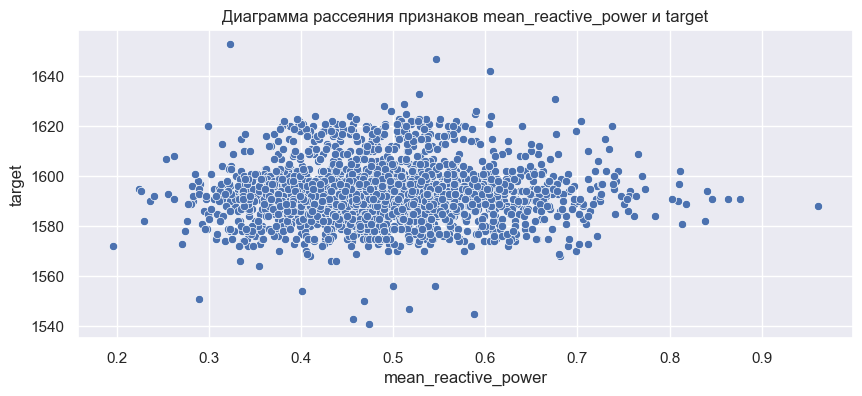

Количественный признак 'mean_reactive_power' принимает значения в диапазоне от 0.196228 до 0.96. Среднее значение признака 'mean_reactive_power' - 0.49, медианное - 0.48. Величина стандартного отклонения: 0.10. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 1.891197286236244e-20.

          === Входной признак 'total_time_delta' ===

Статистики признака:


count    2328.000000
mean      807.808419
std       340.823100
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: total_time_delta, dtype: float64

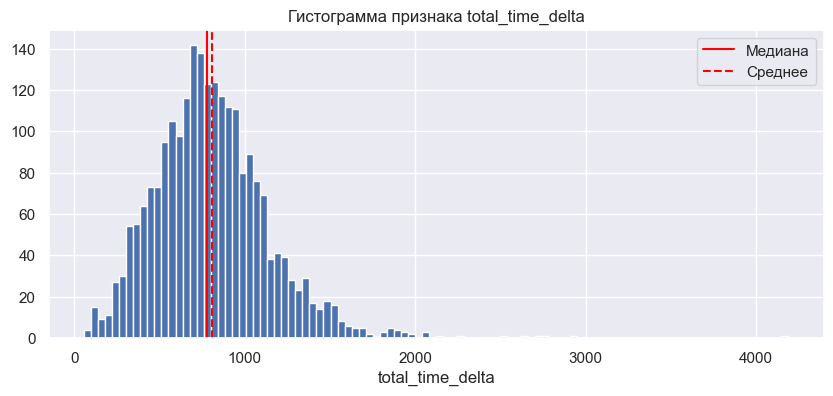

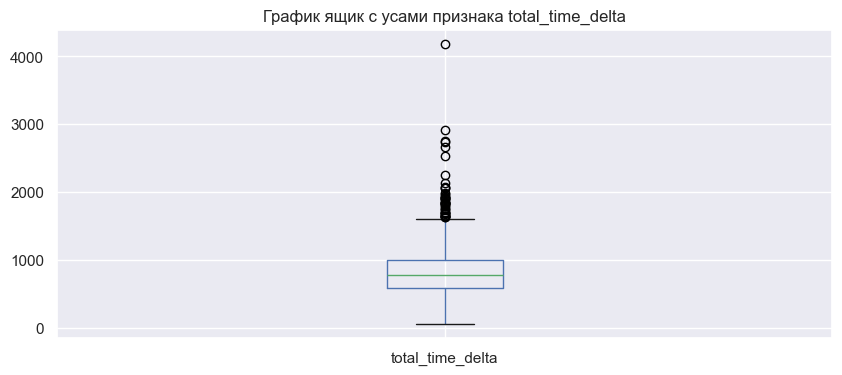

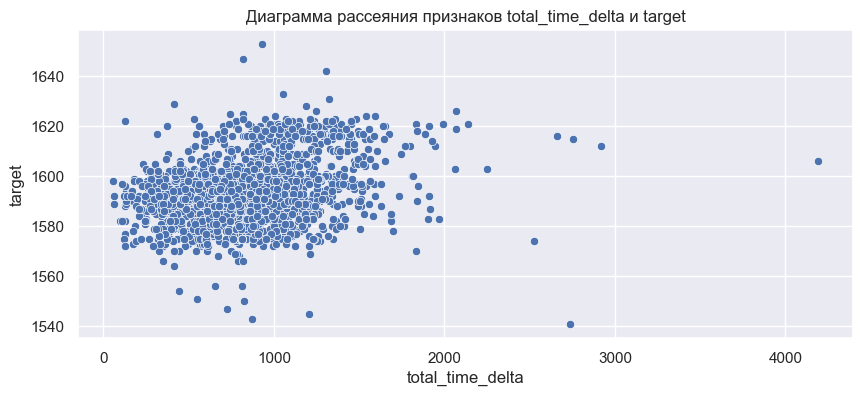

Количественный признак 'total_time_delta' принимает значения в диапазоне от 57.0 до 4189.00. Среднее значение признака 'total_time_delta' - 807.81, медианное - 778.00. Величина стандартного отклонения: 340.82. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 3.837812075630458e-154.

          === Входной признак 'mean_a_r_power_ratio' ===

Статистики признака:


count    2328.000000
mean        1.371462
std         0.065999
min         1.099589
25%         1.329124
50%         1.372071
75%         1.414713
max         1.663366
Name: mean_a_r_power_ratio, dtype: float64

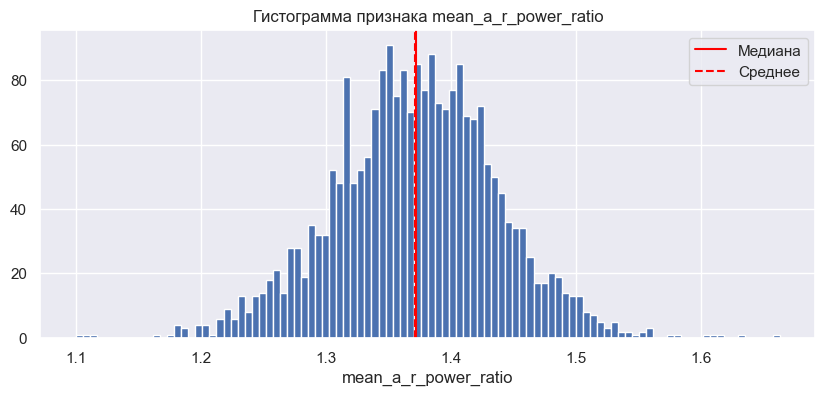

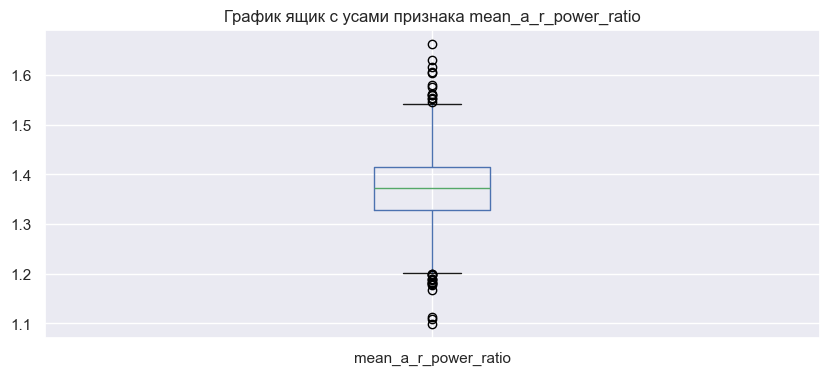

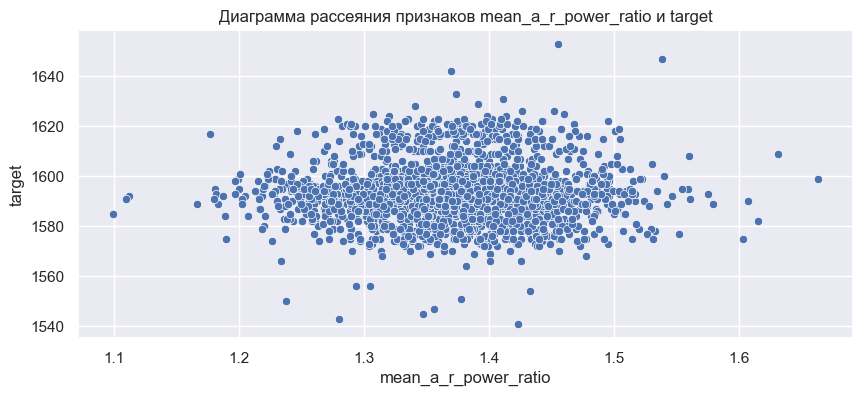

Количественный признак 'mean_a_r_power_ratio' принимает значения в диапазоне от 1.099589496452082 до 1.66. Среднее значение признака 'mean_a_r_power_ratio' - 1.37, медианное - 1.37. Величина стандартного отклонения: 0.07. Распределение признака похоже на нормальное. Значение p-value теста на нормальность распределения: 2.8947271865831343e-05.

          === Входной признак 'mean_power' ===

Статистики признака:


count    2328.000000
mean        0.825539
std         0.160341
min         0.331897
25%         0.714277
50%         0.818302
75%         0.921148
max         1.572238
Name: mean_power, dtype: float64

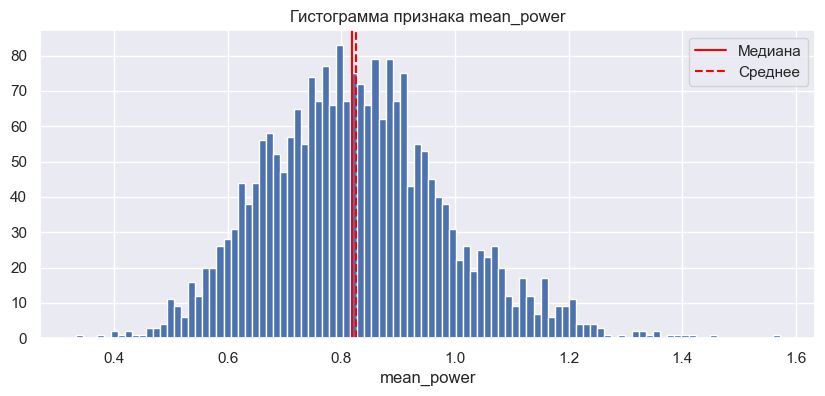

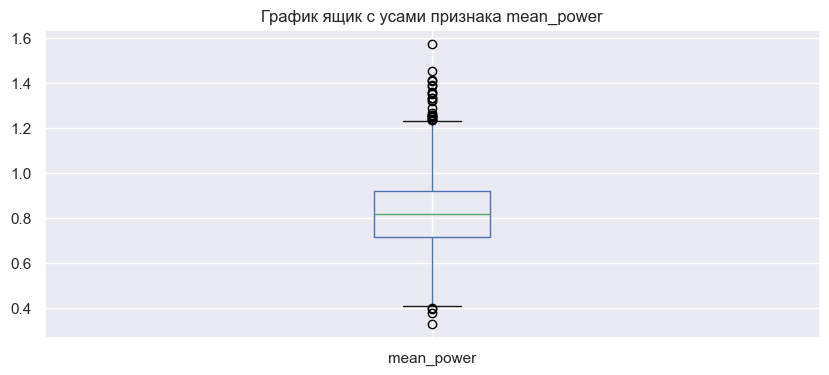

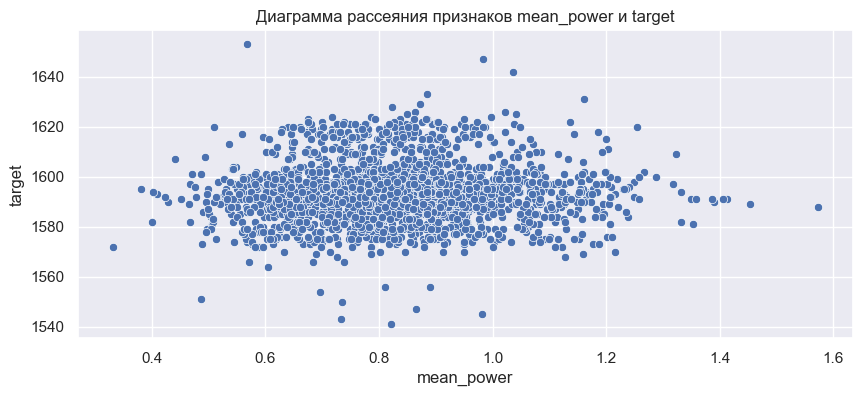

Количественный признак 'mean_power' принимает значения в диапазоне от 0.3318973771514322 до 1.57. Среднее значение признака 'mean_power' - 0.83, медианное - 0.82. Величина стандартного отклонения: 0.16. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 6.996997983444428e-16.

          === Входной признак 'total_active_energy' ===

Статистики признака:


count    2328.000000
mean      539.107742
std       257.280972
min        26.187544
25%       368.187260
50%       508.260683
75%       678.508092
max      3718.054401
Name: total_active_energy, dtype: float64

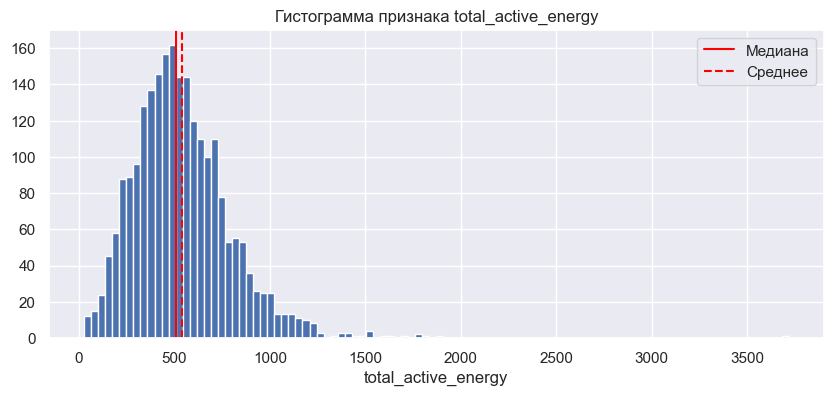

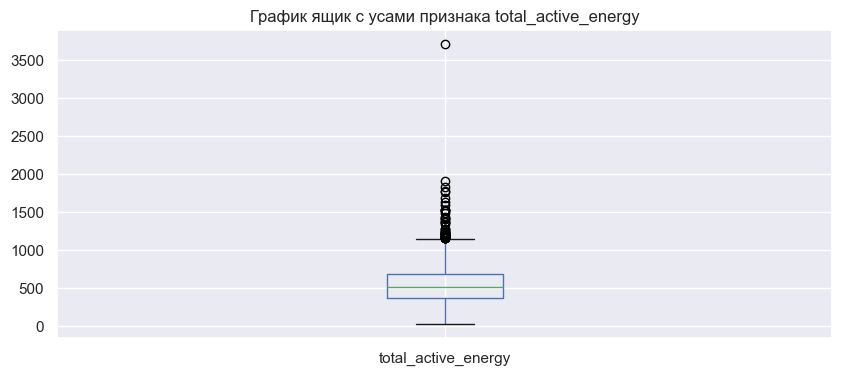

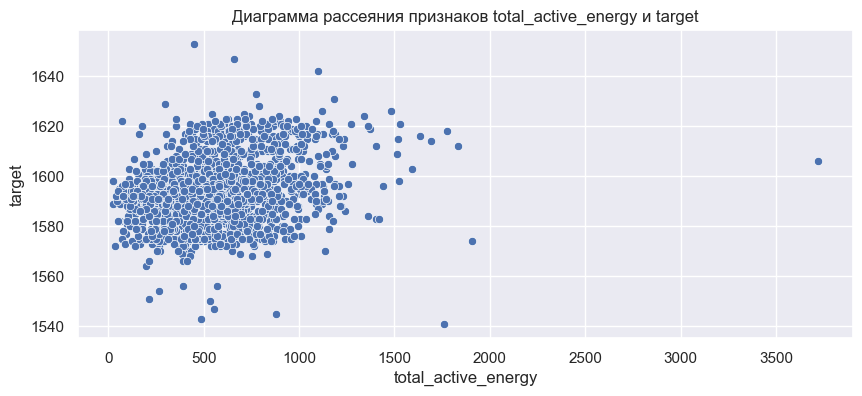

Количественный признак 'total_active_energy' принимает значения в диапазоне от 26.187544000000003 до 3718.05. Среднее значение признака 'total_active_energy' - 539.11, медианное - 508.26. Величина стандартного отклонения: 257.28. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 5.202238082731426e-216.

          === Входной признак 'total_reactive_energy' ===

Статистики признака:


count    2328.000000
mean      396.477111
std       189.655454
min        20.779589
25%       270.443382
50%       371.695841
75%       495.136516
max      2612.081299
Name: total_reactive_energy, dtype: float64

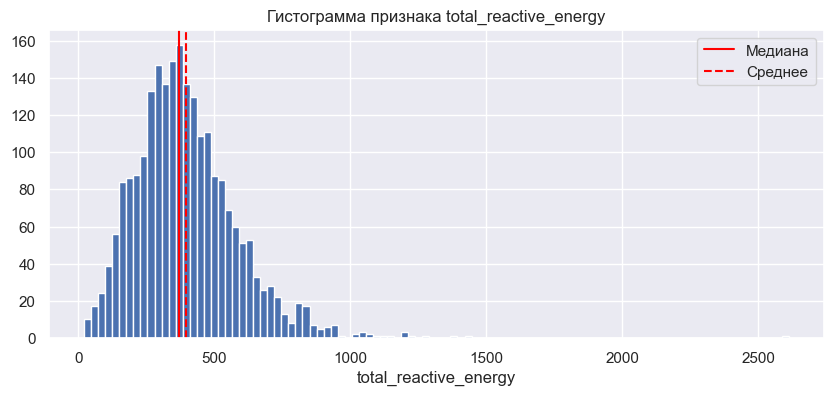

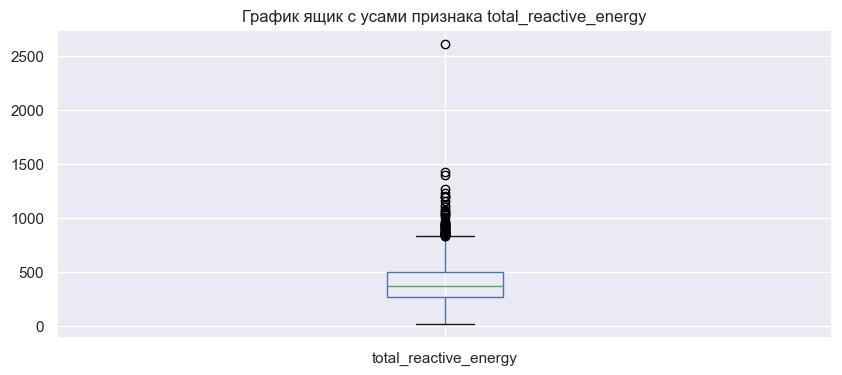

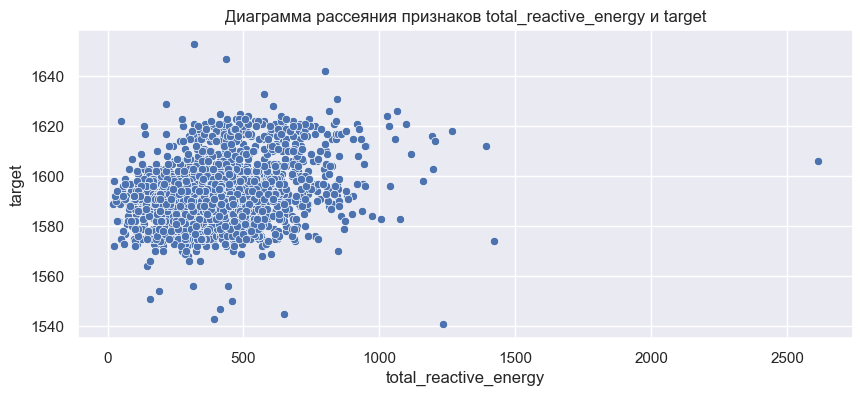

Количественный признак 'total_reactive_energy' принимает значения в диапазоне от 20.779589 до 2612.08. Среднее значение признака 'total_reactive_energy' - 396.48, медианное - 371.70. Величина стандартного отклонения: 189.66. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 2.747421211359001e-195.

          === Входной признак 'total_energy_spent' ===

Статистики признака:


count    2328.000000
mean      669.912912
std       319.493496
min        33.430208
25%       457.870652
50%       630.813815
75%       841.459596
max      4546.405812
Name: total_energy_spent, dtype: float64

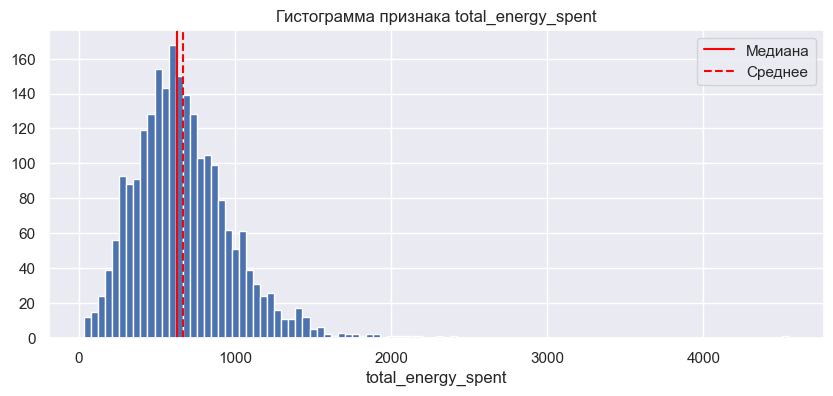

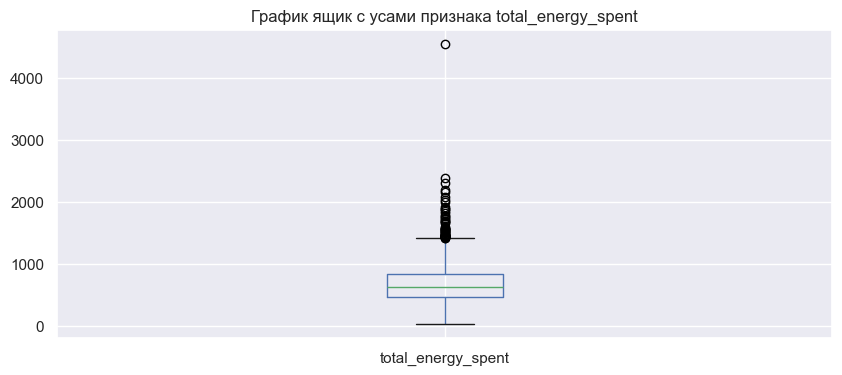

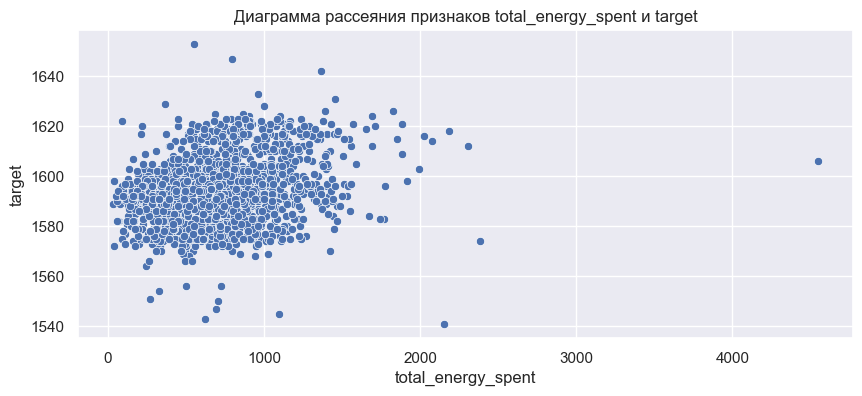

Количественный признак 'total_energy_spent' принимает значения в диапазоне от 33.43020759374457 до 4546.41. Среднее значение признака 'total_energy_spent' - 669.91, медианное - 630.81. Величина стандартного отклонения: 319.49. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 6.939756327016766e-209.

          === Входной признак 'latest_active_power' ===

Статистики признака:


count    2328.000000
mean        0.659223
std         0.257138
min         0.228852
25%         0.458878
50%         0.594562
75%         0.823847
max         1.463773
Name: latest_active_power, dtype: float64

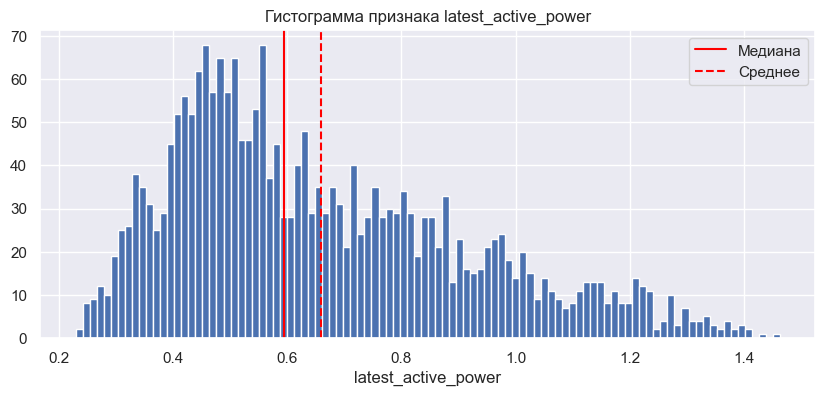

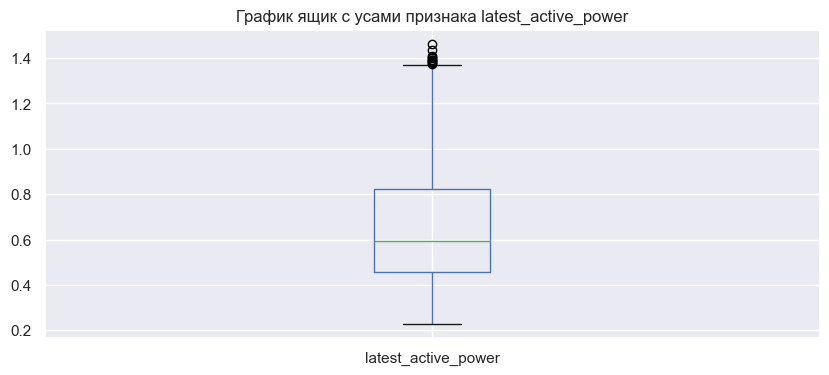

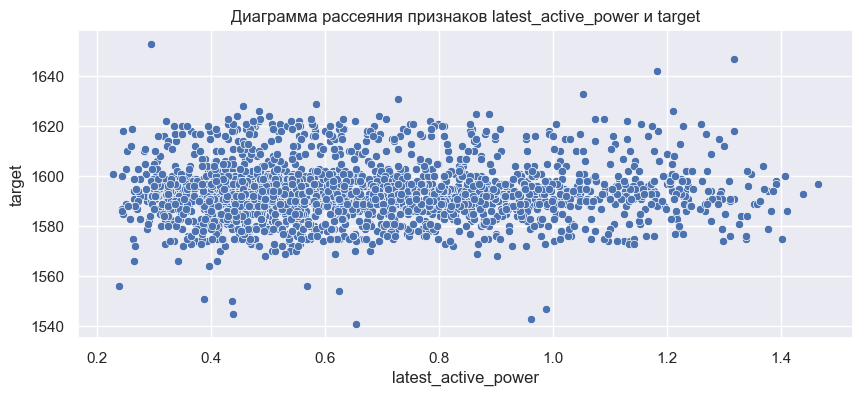

Количественный признак 'latest_active_power' принимает значения в диапазоне от 0.228852 до 1.46. Среднее значение признака 'latest_active_power' - 0.66, медианное - 0.59. Величина стандартного отклонения: 0.26. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 2.9100429133441392e-39.

          === Входной признак 'latest_reactive_power' ===

Статистики признака:


count    2328.000000
mean        0.485009
std         0.194807
min         0.153777
25%         0.336176
50%         0.440239
75%         0.609231
max         1.188563
Name: latest_reactive_power, dtype: float64

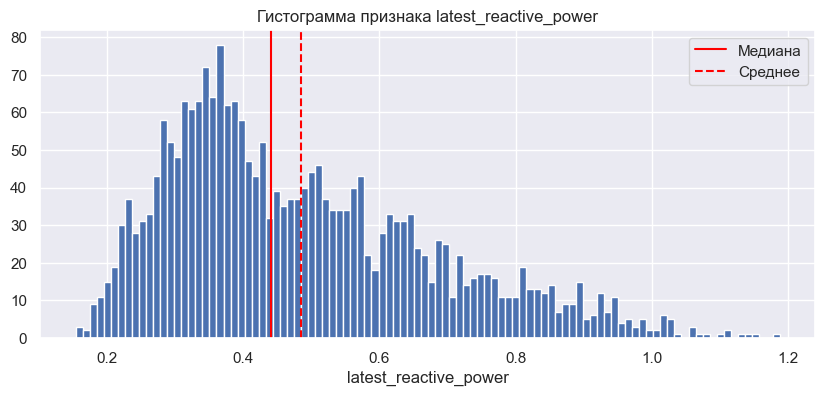

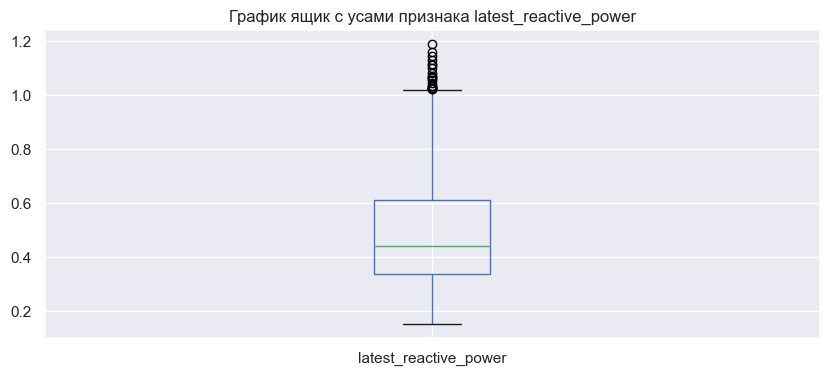

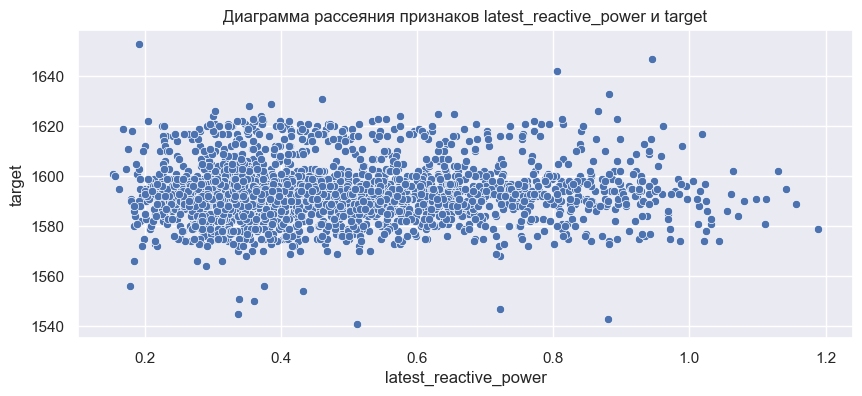

Количественный признак 'latest_reactive_power' принимает значения в диапазоне от 0.153777 до 1.19. Среднее значение признака 'latest_reactive_power' - 0.49, медианное - 0.44. Величина стандартного отклонения: 0.19. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 3.133623725532679e-43.

          === Входной признак 'latest_time_delta' ===

Статистики признака:


count    2328.000000
mean      117.938574
std        62.817100
min        11.000000
25%        72.000000
50%       103.000000
75%       147.250000
max       555.000000
Name: latest_time_delta, dtype: float64

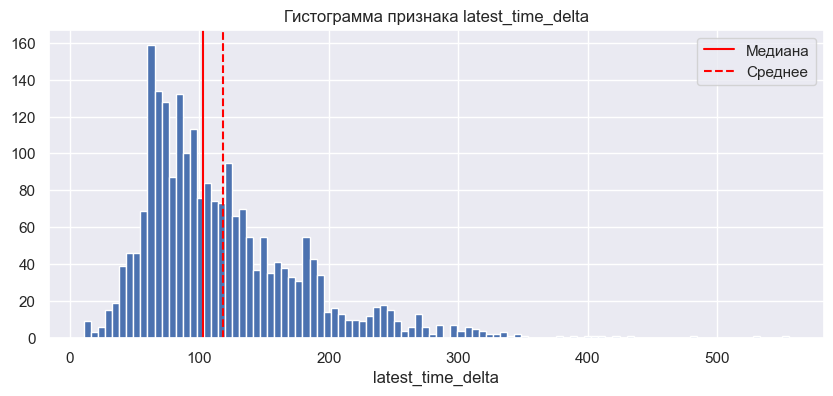

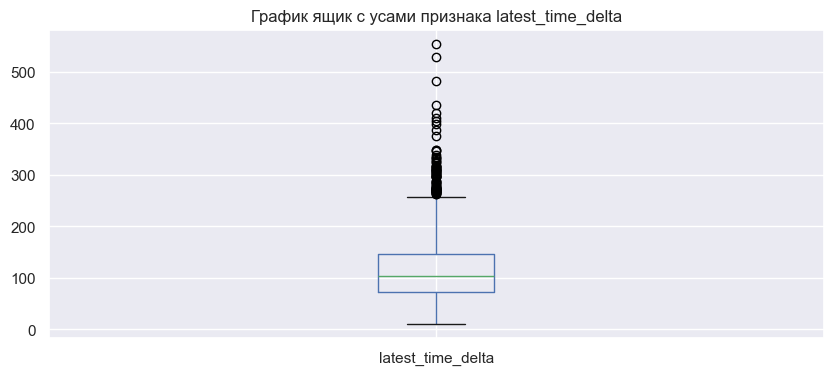

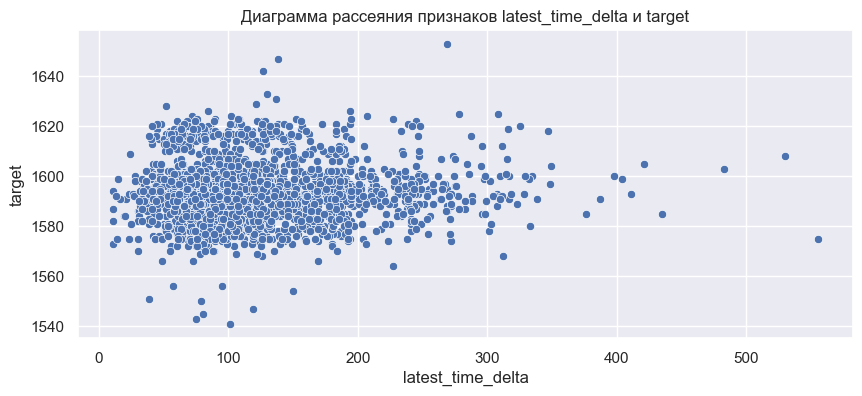

Количественный признак 'latest_time_delta' принимает значения в диапазоне от 11.0 до 555.00. Среднее значение признака 'latest_time_delta' - 117.94, медианное - 103.00. Величина стандартного отклонения: 62.82. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 8.248248502781837e-157.

          === Входной признак 'latest_heat_iteration_rank' ===

Частоты значений признака:


4     637
5     560
6     382
3     356
7     151
2     113
8      66
1      25
9      21
10      7
11      3
12      2
13      2
15      2
16      1
Name: latest_heat_iteration_rank, dtype: int64

Всего категорий в признаке: 15


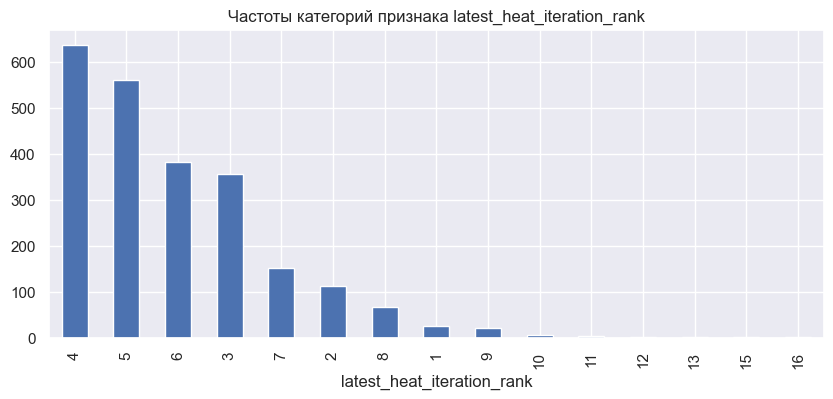

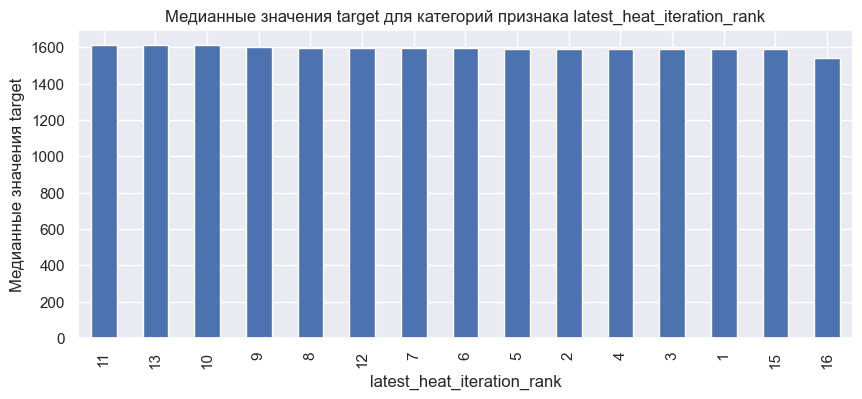

Перед нами дискретный числовой параметр. Значениями столбца 'latest_heat_iteration_rank' являются: 4, 5, 6, 3, 7, 2, 8, 1, 9, 10, 11, 12, 13, 15, ... 
Чаще всего (637 строк или 27.36% наблюдений) признак 'latest_heat_iteration_rank' принимает значение '4', в наименьшем количестве наблюдений (1 строка  или 0.04% наблюдений) этот признак принимает значение '16'.

          === Входной признак 'latest_a_r_power_ratio' ===

Статистики признака:


count    2328.000000
mean        1.371388
std         0.132539
min         1.019565
25%         1.277084
50%         1.377406
75%         1.470055
max         1.768240
Name: latest_a_r_power_ratio, dtype: float64

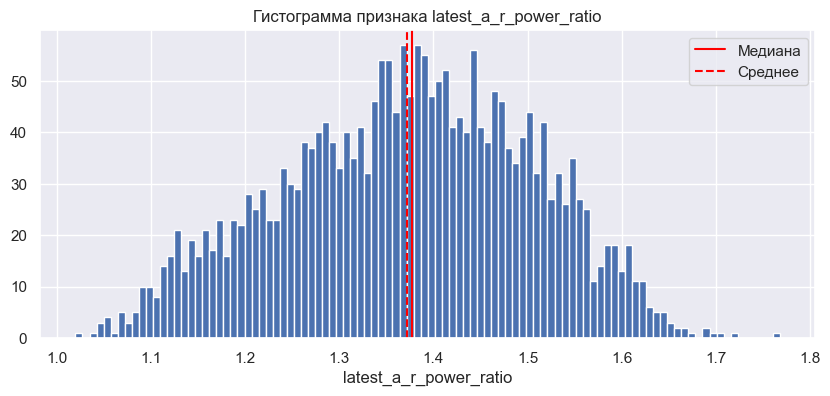

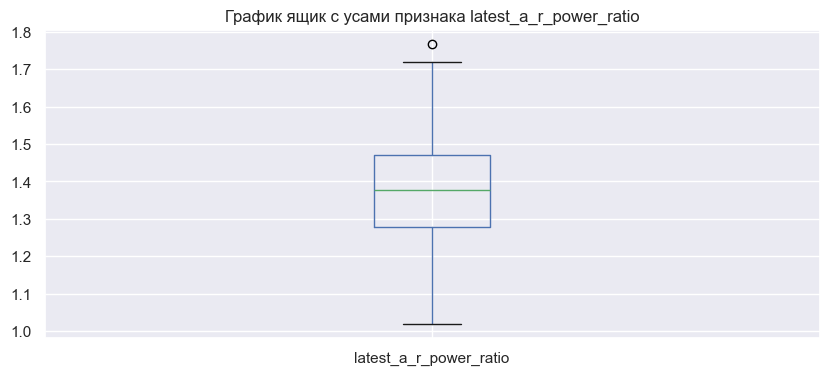

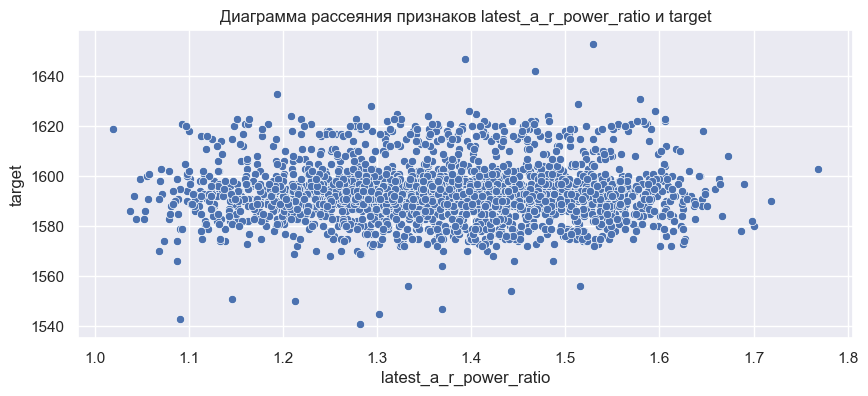

Количественный признак 'latest_a_r_power_ratio' принимает значения в диапазоне от 1.01956513612859 до 1.77. Среднее значение признака 'latest_a_r_power_ratio' - 1.37, медианное - 1.38. Величина стандартного отклонения: 0.13. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 3.6999689939271544e-17.

          === Входной признак 'latest_power' ===

Статистики признака:


count    2328.000000
mean        0.819322
std         0.320294
min         0.275718
25%         0.572066
50%         0.741100
75%         1.024660
max         1.783585
Name: latest_power, dtype: float64

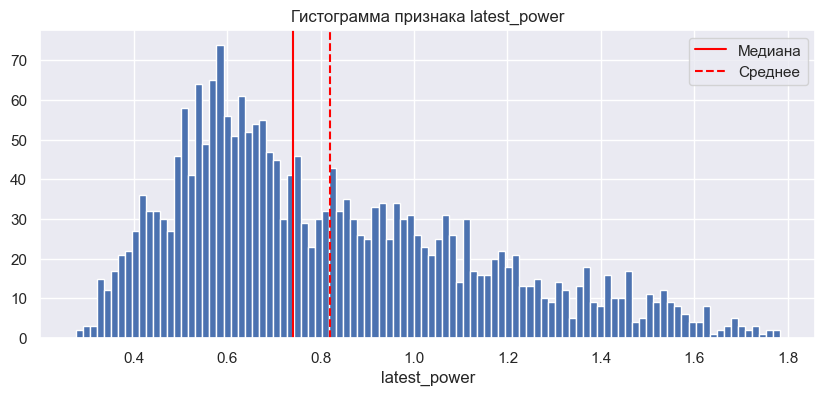

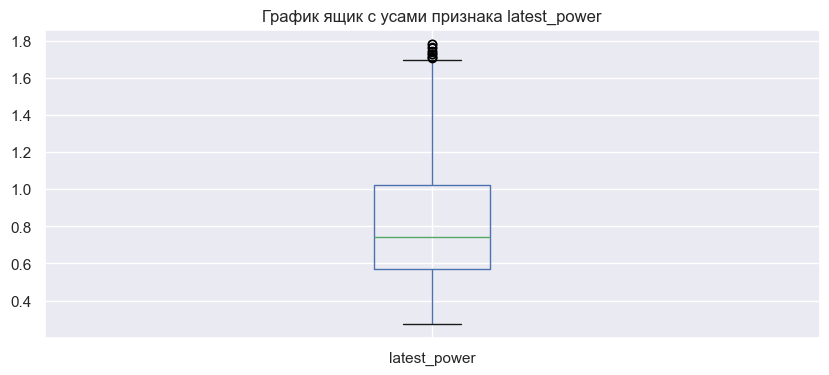

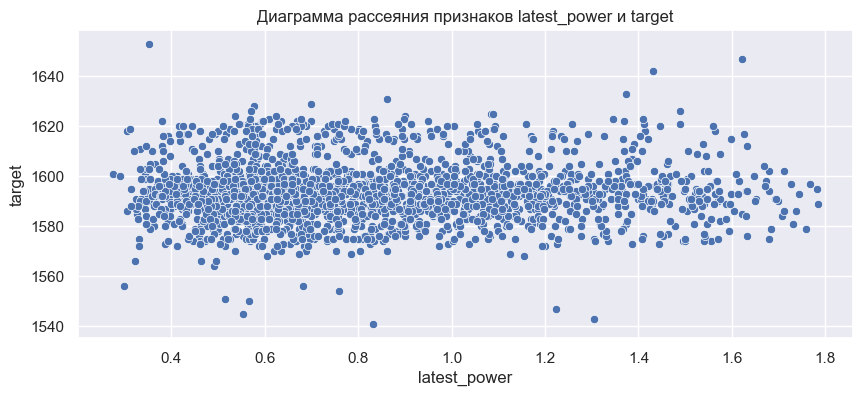

Количественный признак 'latest_power' принимает значения в диапазоне от 0.2757183411255044 до 1.78. Среднее значение признака 'latest_power' - 0.82, медианное - 0.74. Величина стандартного отклонения: 0.32. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 3.0764103348676875e-39.

          === Входной признак 'latest_active_energy' ===

Статистики признака:


count    2328.000000
mean       78.044111
std        53.135237
min         5.246505
25%        40.792907
50%        63.570512
75%        99.569311
max       375.579880
Name: latest_active_energy, dtype: float64

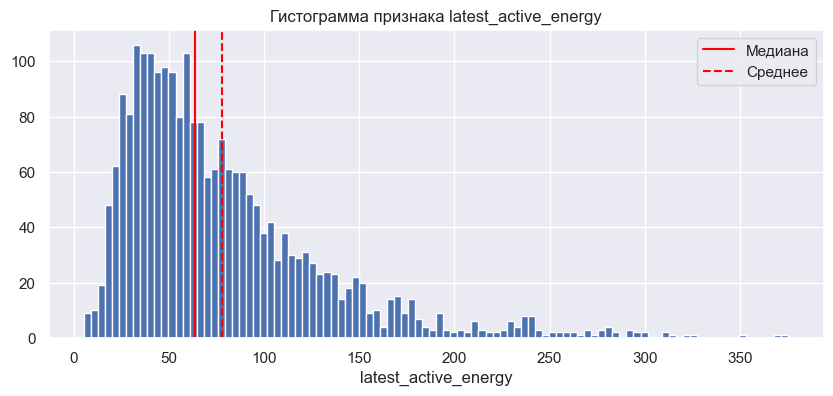

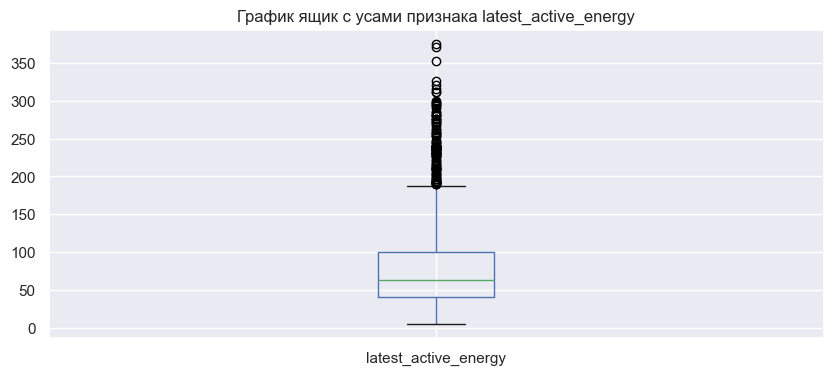

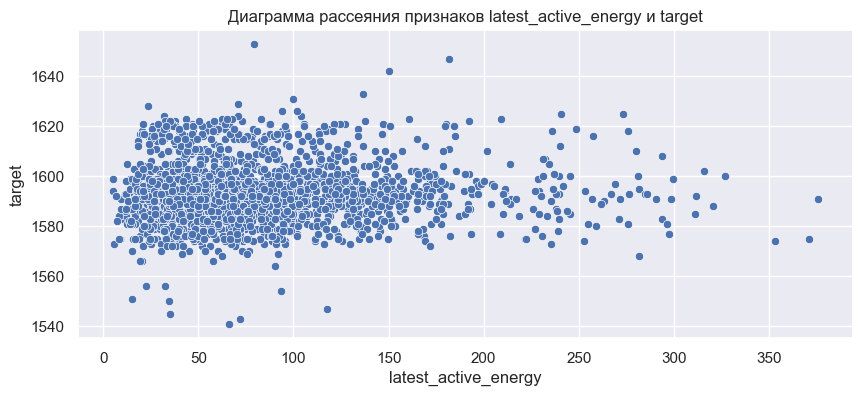

Количественный признак 'latest_active_energy' принимает значения в диапазоне от 5.246505000000001 до 375.58. Среднее значение признака 'latest_active_energy' - 78.04, медианное - 63.57. Величина стандартного отклонения: 53.14. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 2.172024126294976e-171.

          === Входной признак 'latest_reactive_energy' ===

Статистики признака:


count    2328.000000
mean       57.398419
std        39.623618
min         3.566134
25%        29.687389
50%        47.063997
75%        72.861560
max       280.760180
Name: latest_reactive_energy, dtype: float64

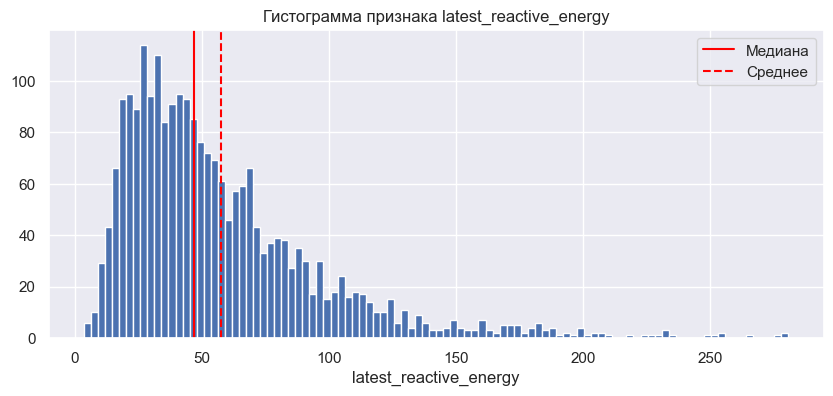

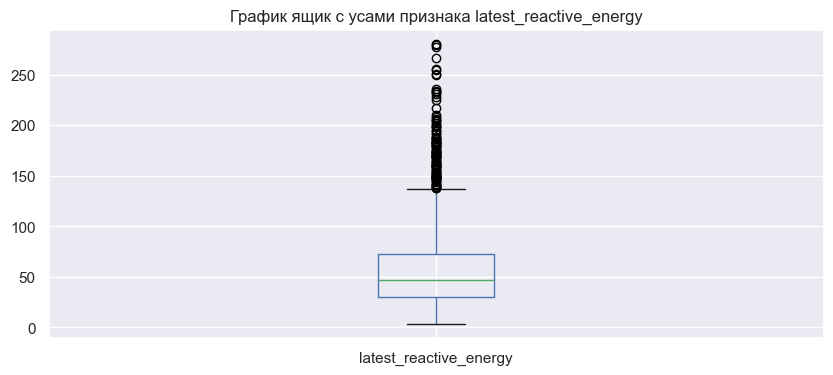

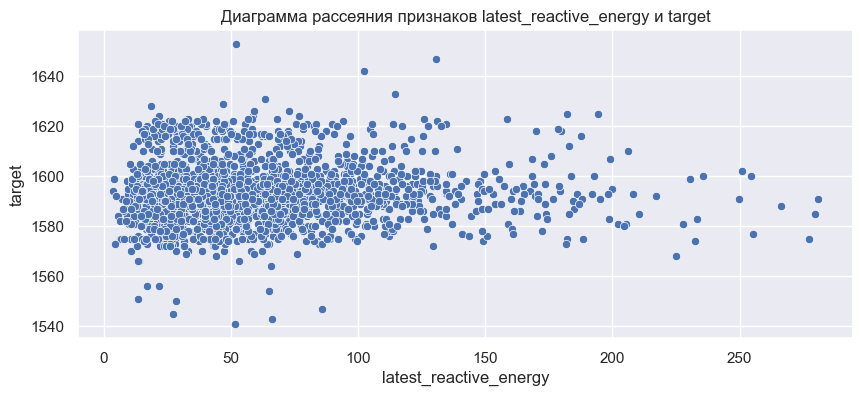

Количественный признак 'latest_reactive_energy' принимает значения в диапазоне от 3.566134 до 280.76. Среднее значение признака 'latest_reactive_energy' - 57.40, медианное - 47.06. Величина стандартного отклонения: 39.62. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 4.032214387881168e-185.

          === Входной признак 'latest_energy_spent' ===

Статистики признака:


count    2328.000000
mean       96.985916
std        66.125407
min         6.409531
25%        50.368210
50%        78.902054
75%       123.595632
max       468.920596
Name: latest_energy_spent, dtype: float64

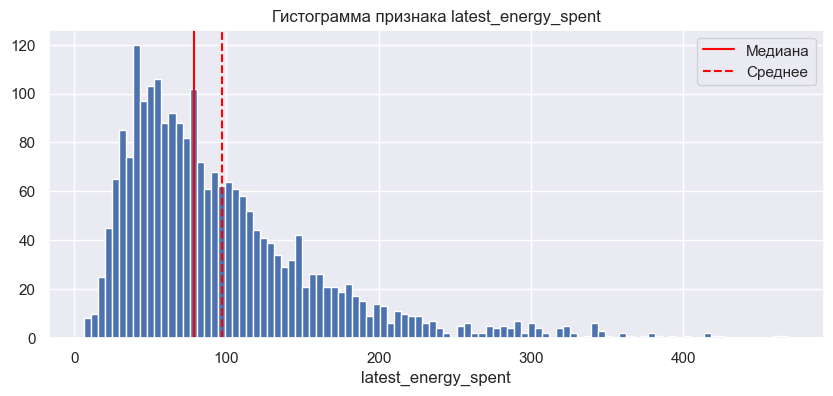

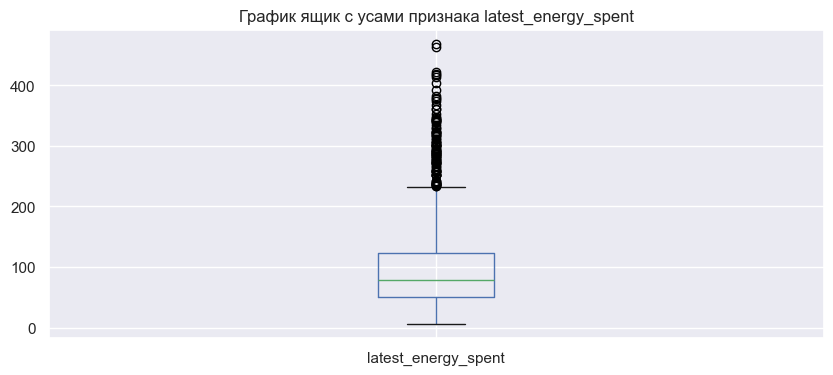

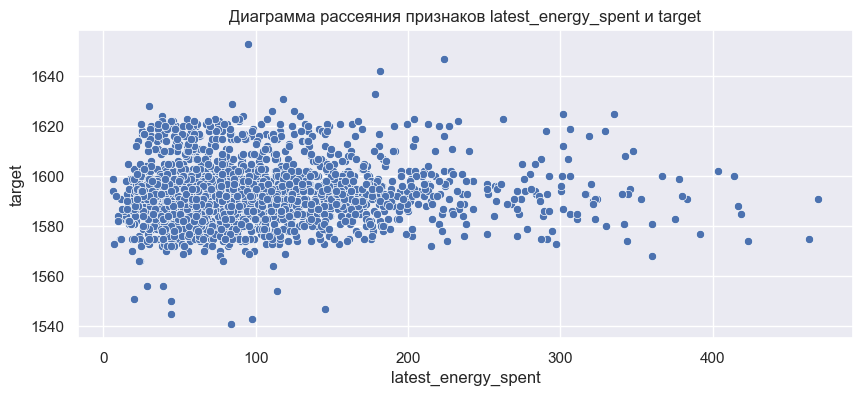

Количественный признак 'latest_energy_spent' принимает значения в диапазоне от 6.409530855986029 до 468.92. Среднее значение признака 'latest_energy_spent' - 96.99, медианное - 78.90. Величина стандартного отклонения: 66.13. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 4.7148739276396435e-174.

          === Входной признак 'total_heat_time' ===

Статистики признака:


count     2328.000000
mean      1992.565292
std       1350.525526
min         57.000000
25%       1323.750000
50%       1744.500000
75%       2397.000000
max      23485.000000
Name: total_heat_time, dtype: float64

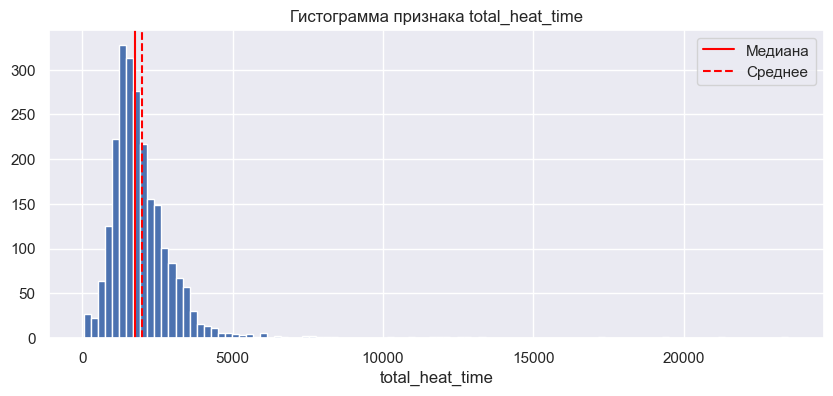

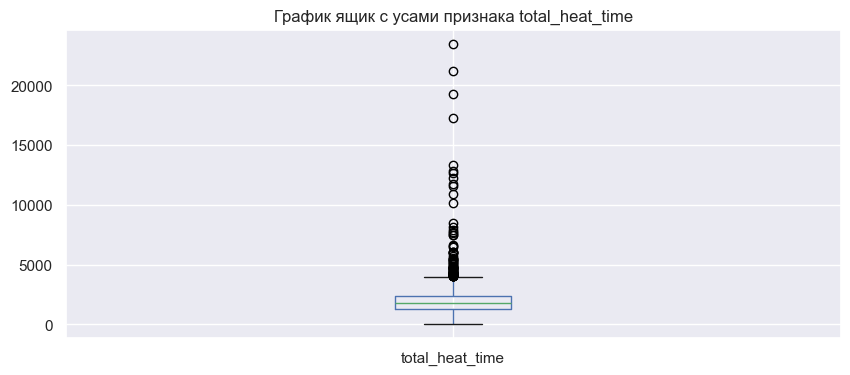

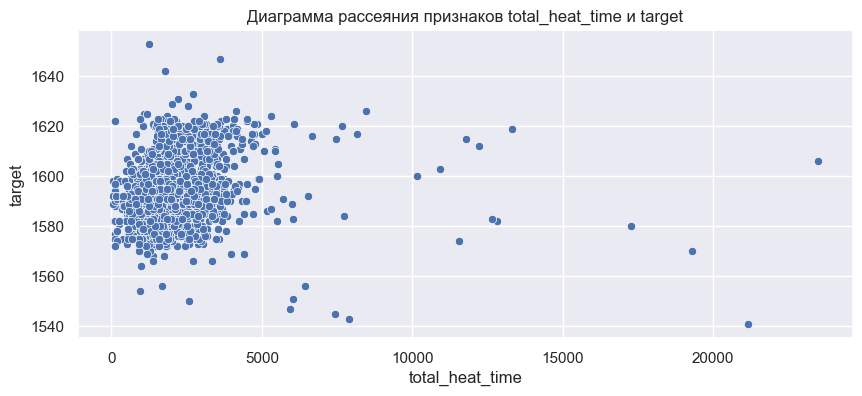

Количественный признак 'total_heat_time' принимает значения в диапазоне от 57.0 до 23485.00. Среднее значение признака 'total_heat_time' - 1992.57, медианное - 1744.50. Величина стандартного отклонения: 1350.53. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.

          === Входной признак 'total_bulk' ===

Статистики признака:


count    2328.000000
mean      609.748282
std       287.605102
min        19.000000
25%       440.000000
50%       609.000000
75%       795.250000
max      3235.000000
Name: total_bulk, dtype: float64

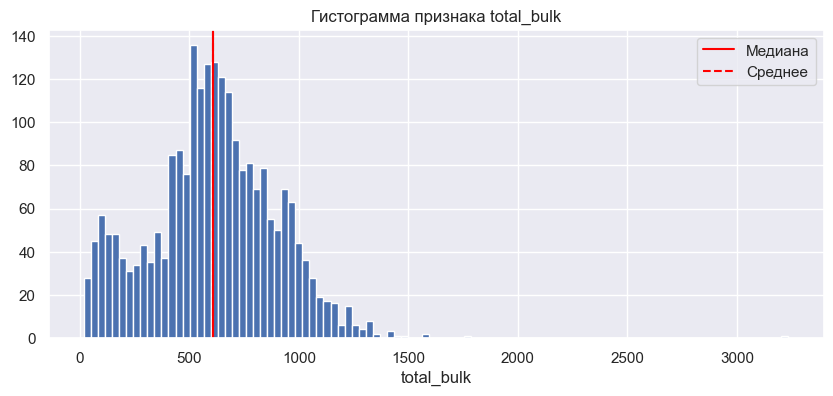

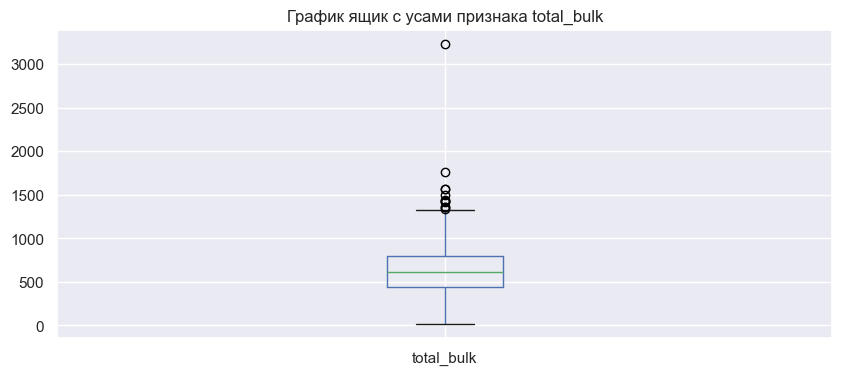

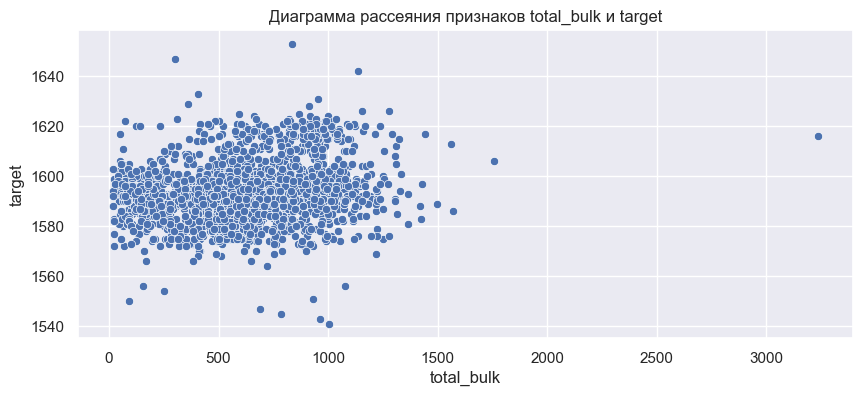

Количественный признак 'total_bulk' принимает значения в диапазоне от 19.0 до 3235.00. Среднее значение признака 'total_bulk' - 609.75, медианное - 609.00. Величина стандартного отклонения: 287.61. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 1.6926799834576177e-43.

          === Входной признак 'total_bulk_time' ===

Статистики признака:


count     2328.000000
mean       986.168814
std        815.745378
min          0.000000
25%        501.000000
50%        894.000000
75%       1340.750000
max      13683.000000
Name: total_bulk_time, dtype: float64

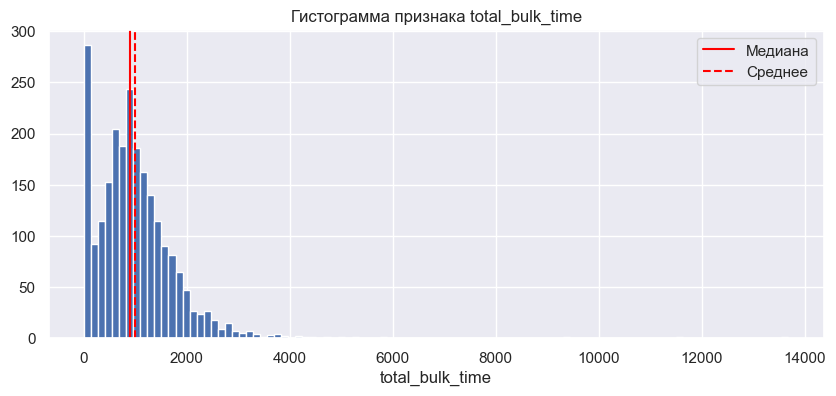

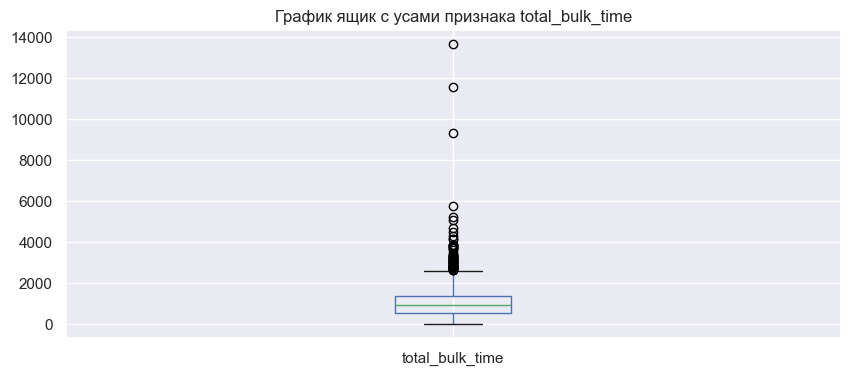

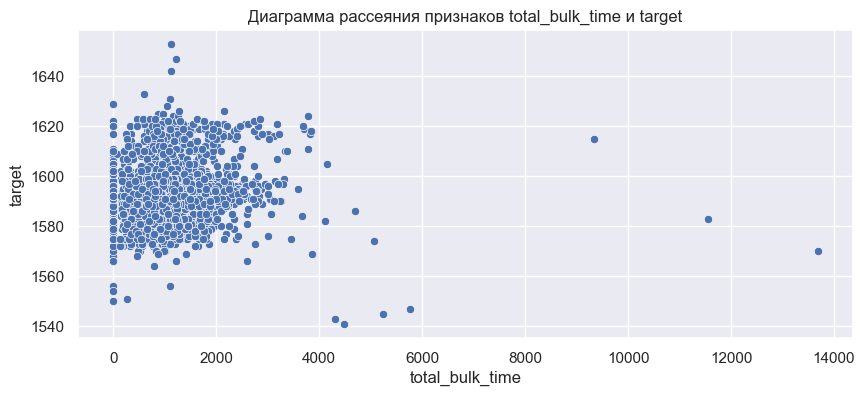

Количественный признак 'total_bulk_time' принимает значения в диапазоне от 0.0 до 13683.00. Среднее значение признака 'total_bulk_time' - 986.17, медианное - 894.00. Величина стандартного отклонения: 815.75. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.

          === Входной признак 'gas' ===

Статистики признака:


count    2328.000000
mean       11.375511
std         6.393413
min         0.008399
25%         7.282534
50%        10.100687
75%        14.216939
max        77.995040
Name: gas, dtype: float64

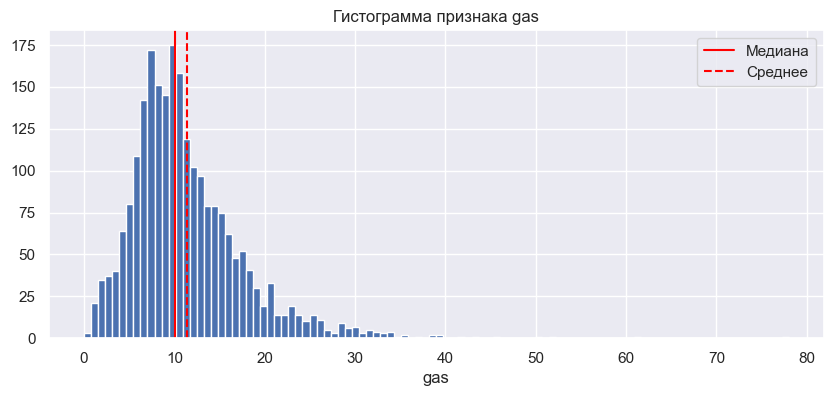

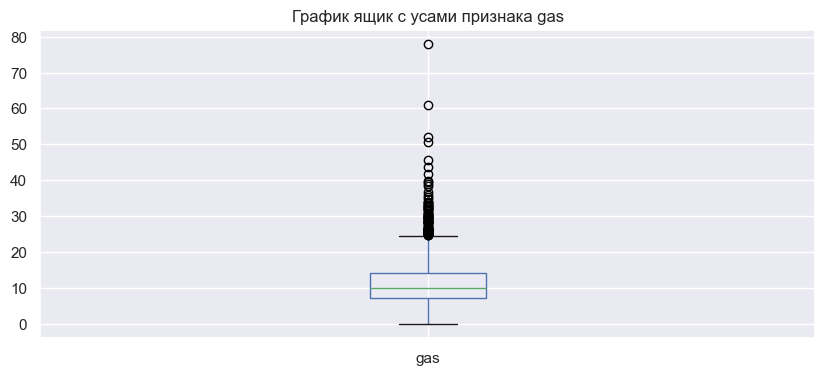

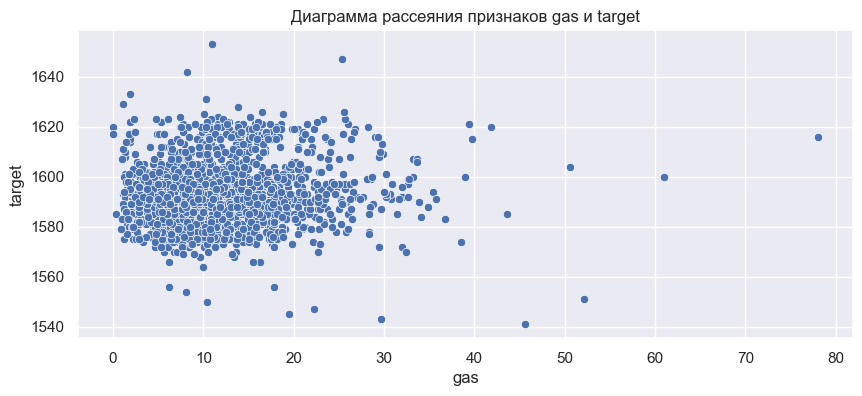

Количественный признак 'gas' принимает значения в диапазоне от 0.0083985291 до 78.00. Среднее значение признака 'gas' - 11.38, медианное - 10.10. Величина стандартного отклонения: 6.39. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 1.2540892098792645e-239.

          === Входной признак 'total_wire' ===

Статистики признака:


count    2328.000000
mean      125.230004
std        63.688634
min         1.918800
25%        89.048700
50%       116.106121
75%       151.582857
max       568.777664
Name: total_wire, dtype: float64

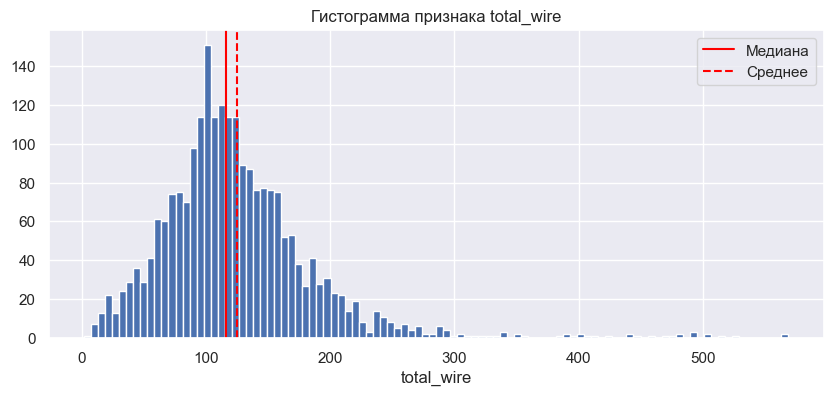

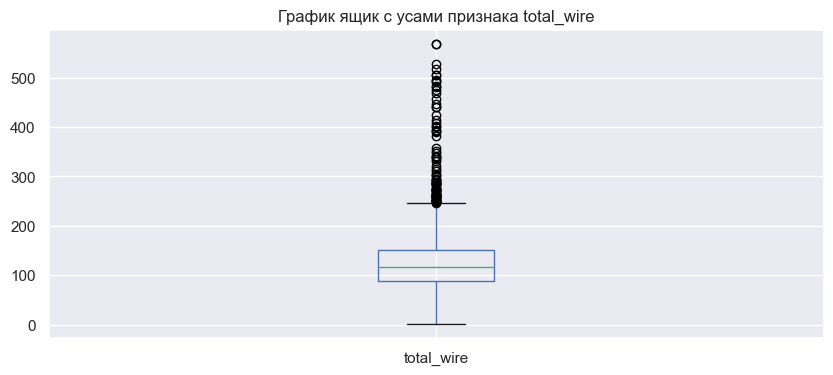

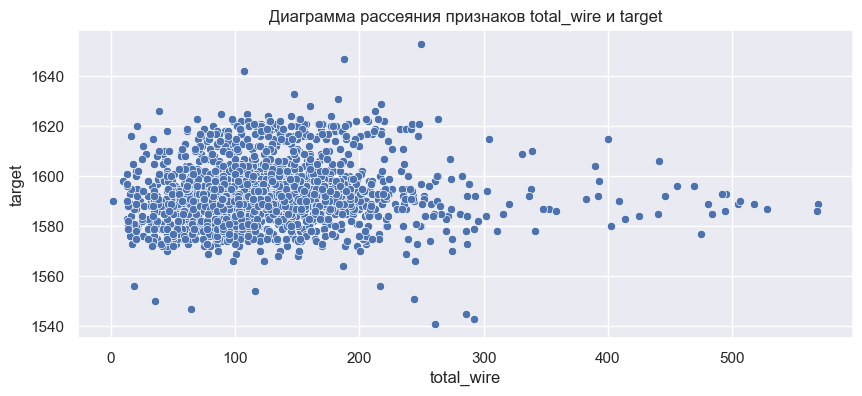

Количественный признак 'total_wire' принимает значения в диапазоне от 1.9188 до 568.78. Среднее значение признака 'total_wire' - 125.23, медианное - 116.11. Величина стандартного отклонения: 63.69. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 5.262049111903587e-242.

          === Входной признак 'total_wire_time' ===

Статистики признака:


count    2328.000000
mean      209.798540
std       390.155892
min         0.000000
25%         0.000000
50%         0.000000
75%       396.250000
max      5937.000000
Name: total_wire_time, dtype: float64

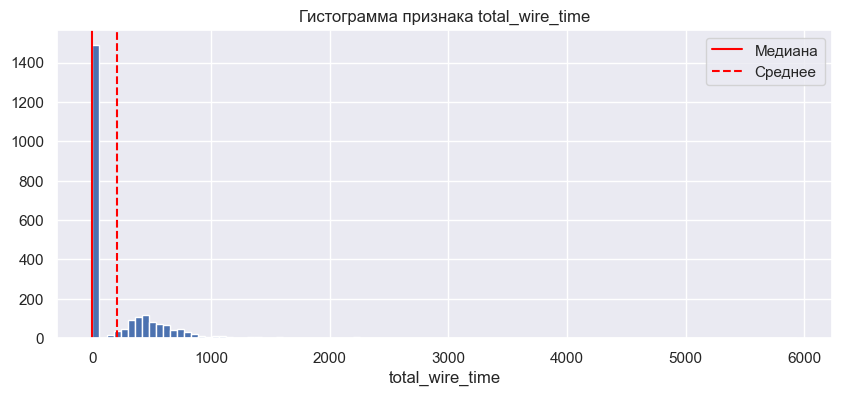

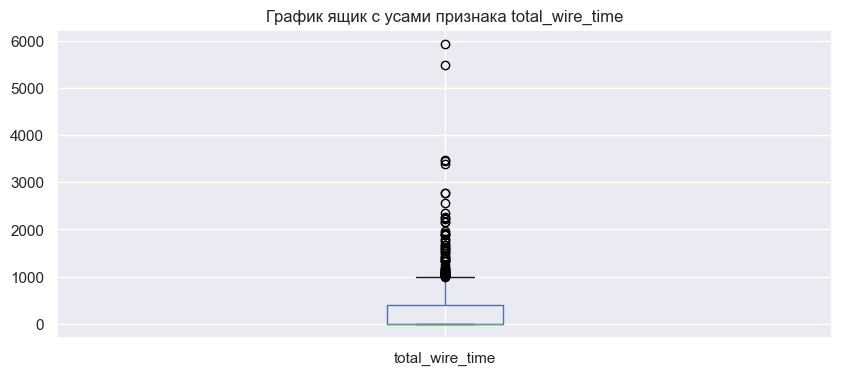

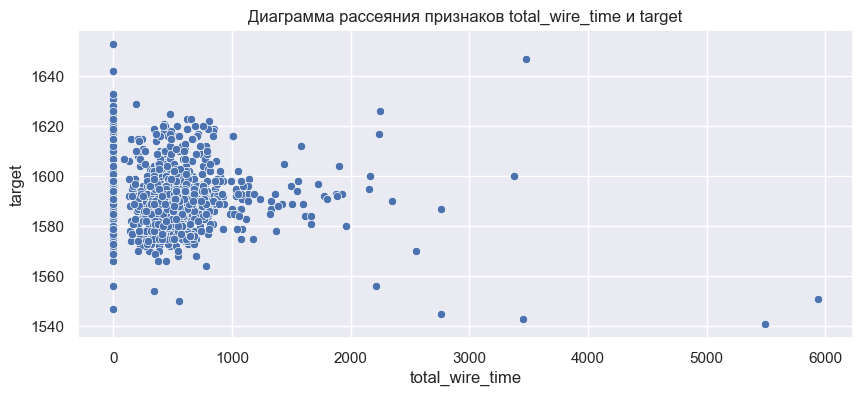

Количественный признак 'total_wire_time' принимает значения в диапазоне от 0.0 до 5937.00. Среднее значение признака 'total_wire_time' - 209.80, медианное - 0.00. Величина стандартного отклонения: 390.16. Можно с достаточной степенью уверенности утверждать, что распределение признака не является нормальным. Значение p-value теста на нормальность распределения: 0.0.


In [87]:
for column in df.columns:
    features = {column: column,
                'target': 'target'}
    describe_feature(df, column, target='target')

Признаки содержат выбросы, не содержат ярко выраженных аномалий и не являются нормально распределенными. На диаграммах рассеяния некоторых признаков можно заметить связь с целевым признаком (в особенности это косается начальной температуры, временных признаков и суммарных "энергетических" признаков).

### 4.7 Корреляционный анализ

Теперь посмотрим на корреляцию признаков.

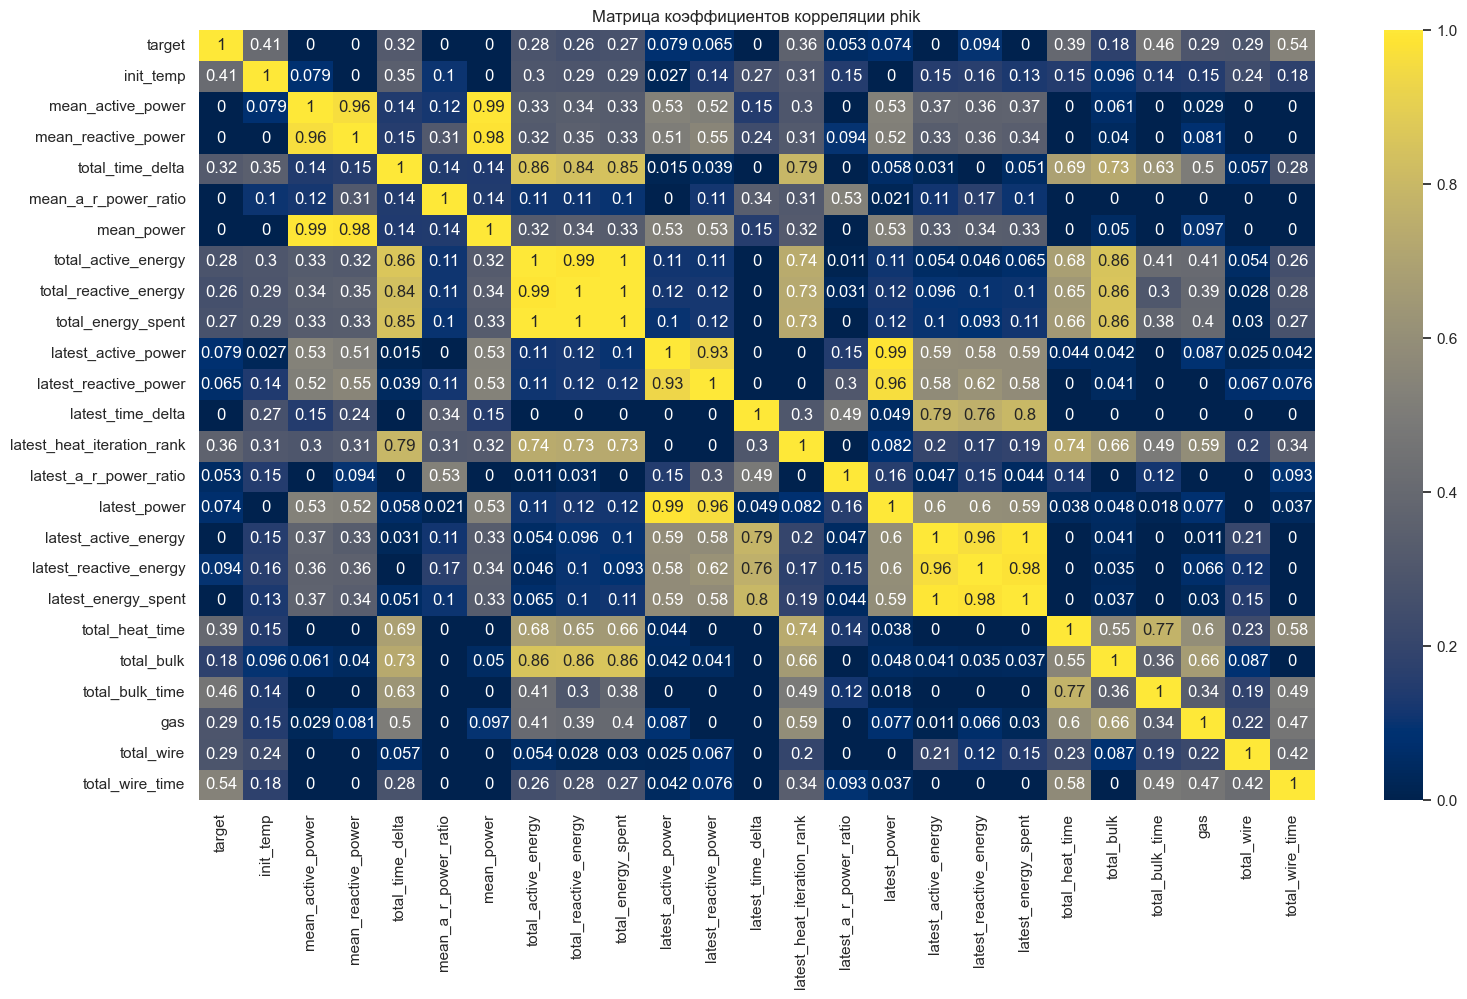

In [88]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.title('Матрица коэффициентов корреляции phik')
sns.heatmap(df.phik_matrix(interval_cols=df.columns), annot=True, cmap='cividis');

Наиболее заметно коррелируют с целевым признаком временные, суммарные ('total') энергетические признаки и признак количества итераций нагрева партии, что в целом подтверждает вывод предыдущего раздела данного проекта. Характеристики последней итерации нагрева не демонстрируют заметной корреляции с целевым признаком. Синтетические признаки при создании которых использовались одни и те же исходные признаки демонстрируют сильную взаимную корреляцию, что вполне ожидаемо.

Итак, мы загрузили данные из файла базы данных в датафреймы, избавились от пропусков и аномалий. Мы создали синтетические временные признаки, характеризующие длительность процессов нагрева и подачи сыпучих и проволочных материалов, демонстрирующие существенную корреляцию с целевым признаком. Кроме того мы создали группу суммарных "энергетических" признаков, характеризующих различные свойства процесса нагрева сырья с точки зрения передачи количества энергии в сумме по всем итерациям. Эта группа признаков также показала заметную корреляцию с целевым признаком. Также, мы создали признак с количеством итераций нагрева (слабо коррелирует с целевым) и группу признаков, характеризующую длительность, мощность и энергию нагрева в последней итерации. Эта группа признаков и признаки, характеризующие среднюю по итерациям мощность нагрева, показали очень слабую или отсутствие корреляции с целевым признаком. 

## 5. Подготовка данных для обучения

Удалим признаки с нулевым коэффициентом phik для целевого признака. Можно ожидать, что этот шаг сделает обучение более устойчивым и уменьшит эффект переобучения модели.

In [89]:
df = df.drop(columns=['latest_energy_spent', 
                      'latest_active_energy', 
                      'latest_time_delta', 
                      'mean_power', 
                      'mean_a_r_power_ratio', 
                      'mean_reactive_power', 
                      'mean_active_power',])

Сформируем тренировочную и тестовую выборки.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
        df.drop(['target'], axis=1),
        df['target'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE,
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1746, 17), (582, 17), (1746,), (582,))

## 6. Обучение и тестирование модели

Очевидно, перед нами стоит задача регрессии. Создадим пайплайн с перебором трех типов моделей: случайный лес, градиентный бустинг и нейронная сеть. Для нейронных сетей данные нормализуем. В пайплайне подберем гиперпараметры на кроссвалидации с помощью случайного поиска.

In [91]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

# Распределение гиперпараметров для каждой модели
param_dist = [
    {  # Random Forest
        'scaler': ['passthrough'],
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 4],
        },
    {  # LGBM Regressor
        'scaler': ['passthrough'],
        'model': [LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)],
        'model__n_estimators': [150, 180, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 4, 5],
        'model__num_leaves': [15, 20, 25],
        'model__subsample': [0.8, 1.0],
    },
    {  # MLP Regressor
        'scaler': [StandardScaler()],
        'model': [MLPRegressor(random_state=RANDOM_STATE)],
        'model__hidden_layer_sizes': [(10,), (10, 10), (5, 5)],
        'model__activation': ['relu', 'tanh'],
        'model__learning_rate_init': [0.001, 0.01],
        'model__max_iter': [200, 300]
    }
]

# Конфигурация RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=156,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)


In [92]:

# Запуск случайного поиска
random_search.fit(X_train, y_train);


Выведем лучшую модель, гиперпараметры и среднее значение метрики на кроссвалидации.

In [93]:
print("Лучшие параметры:\n", random_search.best_params_)
print(f"MAE лучшей модели на кроссвалидации: {-random_search.best_score_}")

Лучшие параметры:
 {'scaler': 'passthrough', 'model__subsample': 0.8, 'model__num_leaves': 15, 'model__n_estimators': 180, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model': LGBMRegressor(max_depth=3, n_estimators=180, num_leaves=15, random_state=210425,
              subsample=0.8, verbosity=-1)}
MAE лучшей модели на кроссвалидации: 6.400282463686001


Сравним результаты трех моделей на кроссвалидации.

In [94]:
results = pd.DataFrame(random_search.cv_results_)
results['param_model'] = results['param_model'].apply(lambda x: str(x))
pd.set_option('display.max_colwidth', None)

In [95]:
(results[['rank_test_score', 'mean_test_score', 'param_model', 'params']]
        .sort_values(by=['rank_test_score'])
        .groupby('param_model', sort=False)
        .head(1))

rank_test_score  mean_test_score  \
88                 1        -6.400282   
1                 33        -6.470505   
139              133        -8.662828   

                                                                                                                      param_model  \
88   LGBMRegressor(max_depth=3, n_estimators=180, num_leaves=15, random_state=210425,\n              subsample=0.8, verbosity=-1)   
1                                                                                      RandomForestRegressor(random_state=210425)   
139                                                                                             MLPRegressor(random_state=210425)   

                                                                                                                                                                                                                                                                                                params  
88   {'scaler': 'passthrough', 'model__subsample': 0.8, 'model__num_leaves': 25, 'model__n_estimators': 180, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model': LGBMRegressor(max_depth=3, n_estimators=180, num_leaves=15, random_state=210425,
              subsample=0.8, verbosity=-1)}  
1                                                                                                    {'scaler': 'passthrough', 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None, 'model': RandomForestRegressor(random_state=210425)}  
139                                                                                            {'scaler': StandardScaler(), 'model__max_iter': 300, 'model__learning_rate_init': 0.01, 'model__hidden_layer_sizes': (10, 10), 'model__activation': 'relu', 'model': MLPRegressor(random_state=210425)}

Модель градиентного бустинга существенно опередила другие модели по метрике на кроссвалидации.

Сформируем предсказания константной модели.

In [96]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)
print('Метрика MAE константной модели:', mean_absolute_error(y_test,
                                                             dummy_regressor.predict(X_test)))
print('Метрика R2 константной модели:', r2_score(y_test,
                                                 dummy_regressor.predict(X_test)))

Метрика MAE константной модели: 8.096255358344848
Метрика R2 константной модели: -0.01236796612710922


Выведем метрики лучшей модели на тестовой выборке.

In [97]:
print('MAE лучшей модели на тесте: ', mean_absolute_error(y_test, 
                                                          random_search.best_estimator_.predict(X_test)))
print('R2 лучшей модели на тесте: ', r2_score(y_test, 
                                              random_search.best_estimator_.predict(X_test)))

MAE лучшей модели на тесте:  6.583035374617343
R2 лучшей модели на тесте:  0.40286207987233713


Лучшая модель удовлетворяет условию ТЗ по метрике MAE. Кроме того, значения метрик лучшей модели значительно превосходят метрики константной модели. Исходя из значения метрики R2, можно заключить, что лучшая модель предсказывает более 40% вариабельности в тестовых данных. Все это позволяет утверждать, что найденная лучшая модель решает задачу данного проекта.

## 7. Анализ важности признаков

Исследуем важность признаков для предсказаний полученной нами модели с помощью анализа shap значений.

In [98]:
# Получим из лучшего пайплайна лучшую модель
best_pipeline = random_search.best_estimator_
best_model = best_pipeline.named_steps['model']

# Создадим explainer, подходящий для градиентного бустинга
explainer = shap.TreeExplainer(best_model)
# Вычислим shap значения
shap_values = explainer.shap_values(X_test)

Сравним важность признаков.

In [99]:
shap_df = pd.DataFrame({
    'features': X_test.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0),
    'lgbm_importance': best_model.feature_importances_
}).sort_values('mean_abs_shap', ascending=False)

print("Топ 10 признаков по среднему абсолютному SHAP значению:")
print(shap_df[['features', 'mean_abs_shap']].reset_index(drop=True).head(10))

Топ 10 признаков по среднему абсолютному SHAP значению:
              features  mean_abs_shap
0     total_time_delta       5.023857
1            init_temp       4.916443
2      total_heat_time       2.754874
3      total_wire_time       1.170892
4           total_wire       1.088653
5  total_active_energy       0.580935
6                  gas       0.528409
7           total_bulk       0.427343
8      total_bulk_time       0.358676
9   total_energy_spent       0.348180


C:\Users\i4074\AppData\Local\Temp\ipykernel_19040\3629852034.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)


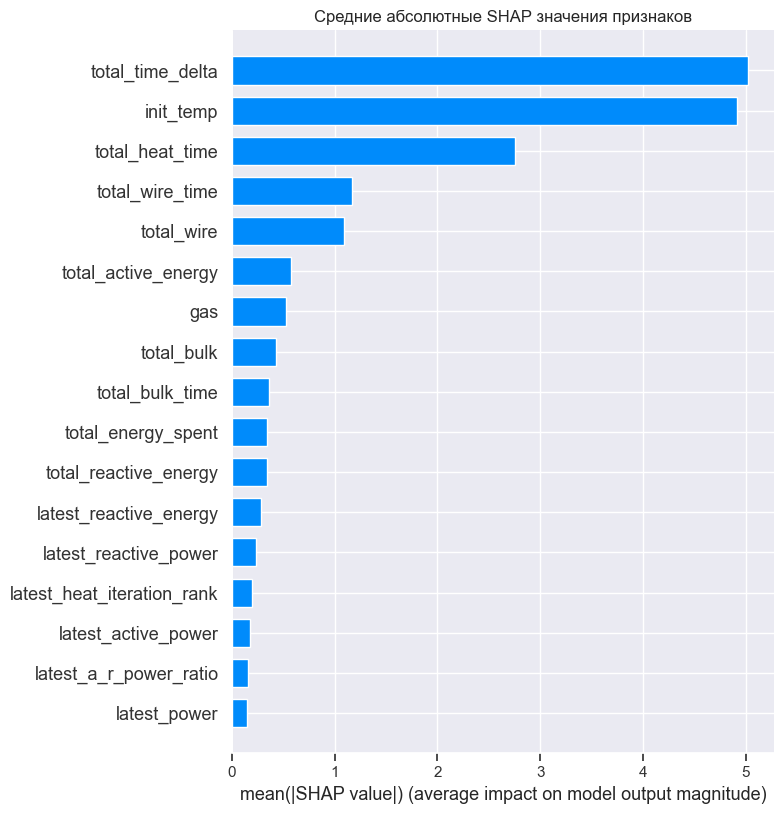

In [100]:
# Столбчатый график (средние абсолютные SHAP значения)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Средние абсолютные SHAP значения признаков")
plt.tight_layout()
plt.show()

Наиболее значимыми признаками являются (в порядке убывания значимости): суммарное время работы электродов, начальная температура сырья, количество секунд от первого включения электродов до последнего отключения, общее время подачи проволочных материалов, общее количество добавленных проволочных материалов, активная мощность электродов, помноженная на время их работы, объем поданного инертного газа, объем сыпучих материалов.

Далее качественно оценим как значения признаков влияют на предсказанную величину.

Взглянем на зависимость SHAP значений от значений соответствующего признака.

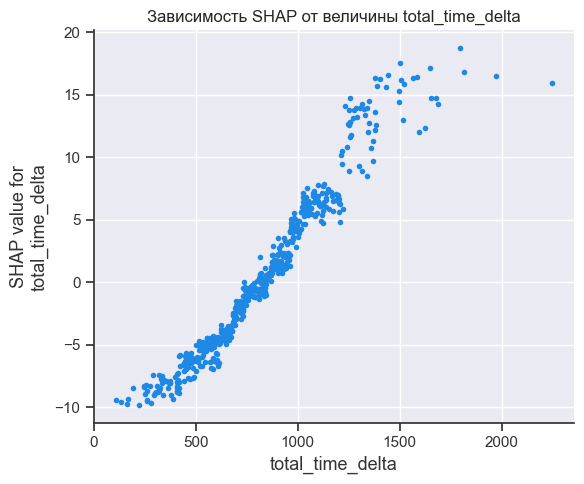

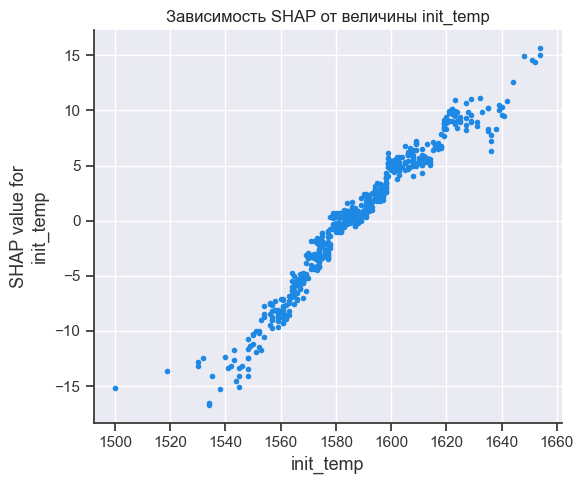

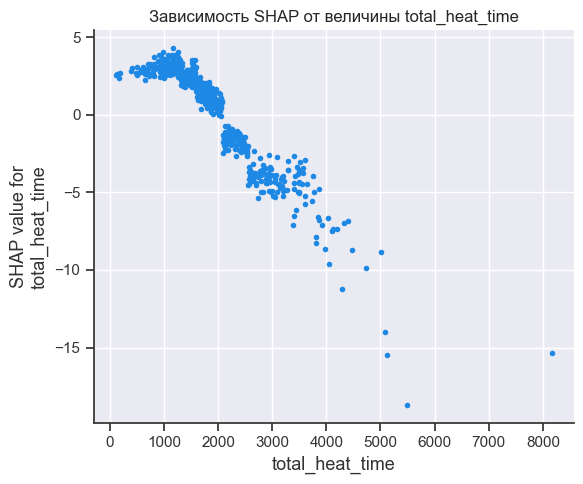

In [101]:
top_features = shap_df.head(3)['features'].tolist()

for feat in top_features:
    shap.dependence_plot(
        feat, 
        shap_values, 
        X_test, 
        interaction_index=None,
        show=False
    )
    plt.title(f"Зависимость SHAP от величины {feat}")
    plt.tight_layout()
    plt.show()

Кроме того, взглянем на вклад признаков в предсказание для нескольких случайно выбранных наблюдений.

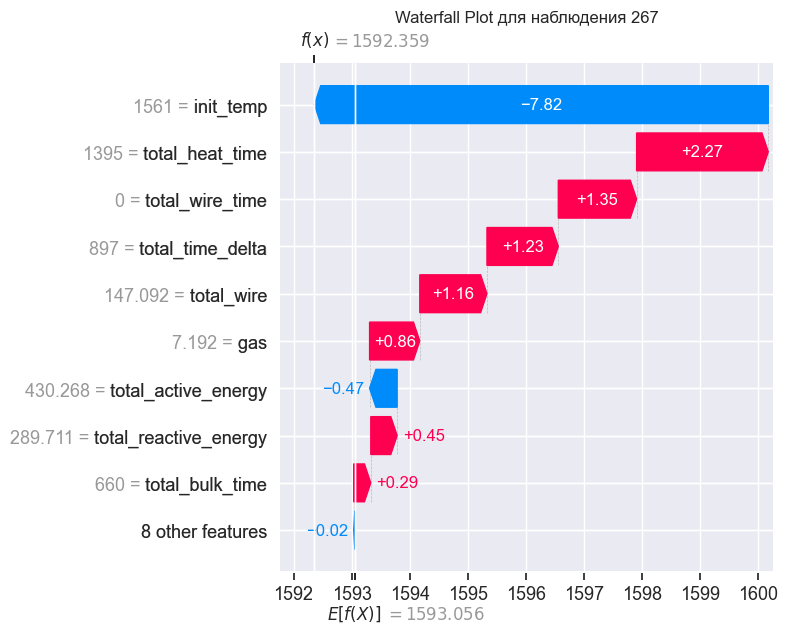

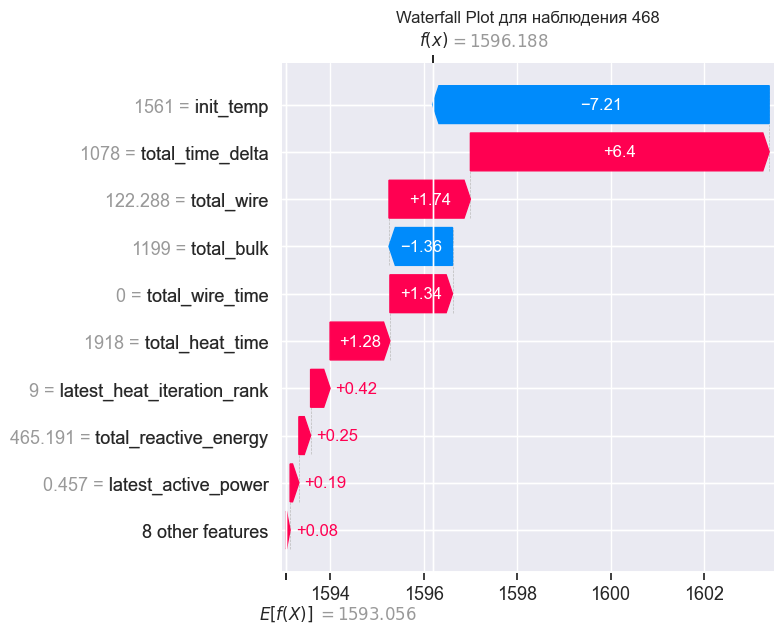

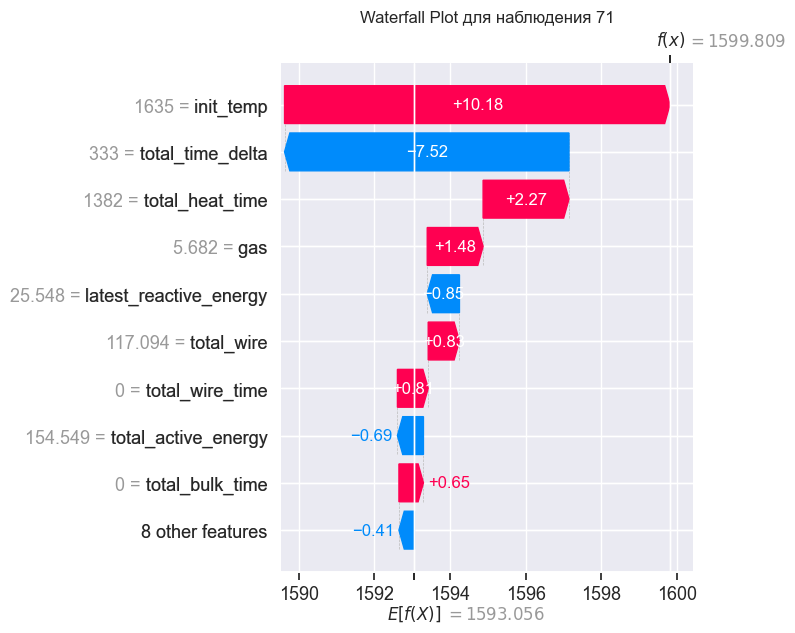

In [102]:
sample_idx = np.random.choice(X_test.shape[0], 3, replace=False)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
for idx in sample_idx:

    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=expected_value,
            data=X_test.iloc[idx],
            feature_names=X_test.columns.tolist()
        ),
        show=False
    )
    plt.title(f"Waterfall Plot для наблюдения {idx}")
    plt.tight_layout()
    plt.show()

Наконец, взглянем на сводную диаграмму вклада значений признаков в величину предсказания.

C:\Users\i4074\AppData\Local\Temp\ipykernel_19040\3749179829.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)


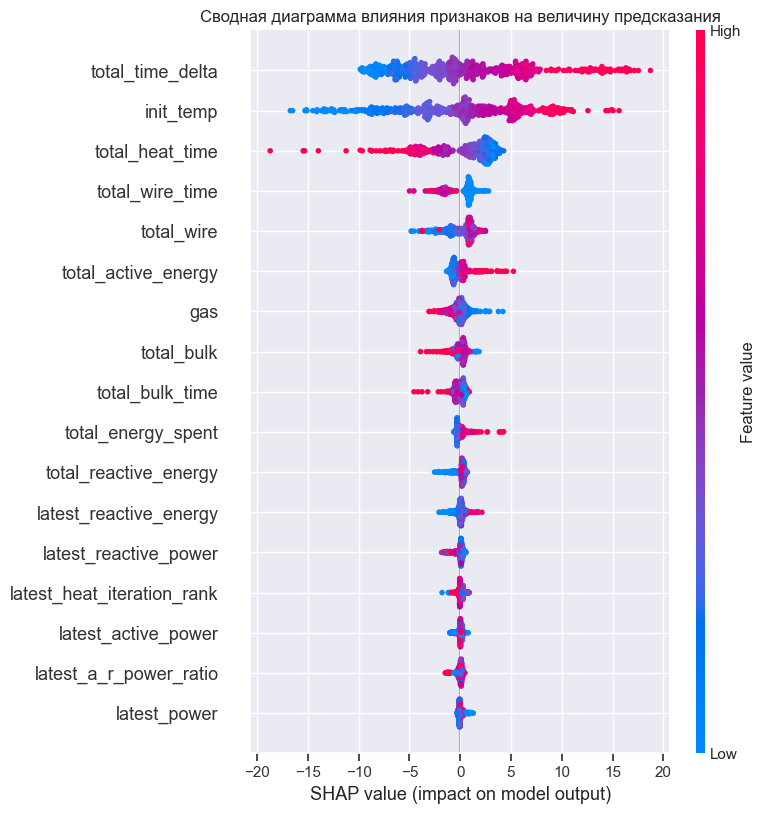

In [103]:
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("Сводная диаграмма влияния признаков на величину предсказания")
plt.tight_layout()
plt.show()

Можно заключить, что в среднем целевую температу увеличивают следующие факторы:  
 - увеличение суммарного времени работы электродов;
 - увеличение начальной температуры;
 - уменьшение времени, проходящего от первого включения электродов, до последнего оключения;
 - уменьшение времени подачи проволочных материалов;
 - увеличение объема проволочных материалов (что в сочетании с предыдущим пунктом означает увеличение скорости подачи проволочных материалов);
 - увеличение количества затраченной на нагрев энергии;
 - уменьшение количества поданного в материал инертного газа.

Эти выводы вполне согласуется с интуитивным пониманием и очевидными физическими соображениями, что подтверждает адекватность построенной модели.

Для иллюстрации посмотрим на зависимость целевой температуры от начальной температуры.

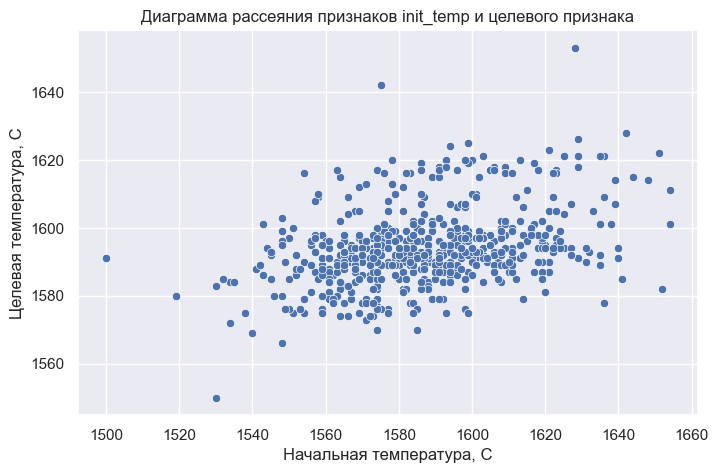

In [104]:
column = 'init_temp'
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=X_test, x=column, y=y_test);
plt.title(f'Диаграмма рассеяния признаков {column} и целевого признака')
plt.xlabel('Начальная температура, C')
plt.ylabel('Целевая температура, C')
plt.show()

На графике заметна положительная корреляция признаков.

## 8. Вывод

Мы загрузили данные из предоставленного файла базы данных, очистили их от пропущенных значений и аномалий. Мы создали синтетические временные признаки, характеризующие длительность процессов нагрева и подачи сыпучих и проволочных материалов, демонстрирующие существенную корреляцию с целевым признаком. Кроме того мы создали группу суммарных "энергетических" признаков, характеризующих различные свойства процесса нагрева сырья с точки зрения передачи количества энергии в сумме по всем итерациям. Эта группа признаков также показала заметную корреляцию с целевым признаком. Также, мы создали признак с количеством итераций нагрева (слабо коррелирует с целевым) и группу признаков, характеризующую длительность, мощность и энергию нагрева в последней итерации. Эта группа признаков и признаки, характеризующие среднюю по итерациям мощность нагрева, показали очень слабую или отсутствие корреляции с целевым признаком.

Далее, мы решили задачу регрессии. Для этого мы создали пайплайн с перебором трех типов моделей: случайный лес, градиентный бустинг и нейронная сеть. Для нейронных сетей данные были нормализованы. В пайплайне были подобраны лучшие гиперпараметры моделей на кроссвалидации с помощью случайного поиска.

Лучшей моделью на кроссвалидации оказалась модель градиентного бустинга. Лучшая модель удовлетворяет условию ТЗ по метрике MAE. Кроме того, значения метрик лучшей модели значительно превосходят метрики константной модели. Исходя из значения метрики R2, можно заключить, что лучшая модель предсказывает более 40% вариабельности в тестовых данных. Все это позволяет утверждать, что найденная лучшая модель решает задачу данного проекта.

Исследовав важность признаков, мы пришли к выводу, что в среднем целевую температу увеличивают следующие факторы:  
 - увеличение суммарного времени работы электродов;
 - увеличение начальной температуры;
 - уменьшение времени, проходящего от первого включения электродов, до последнего оключения;
 - уменьшение времени подачи проволочных материалов;
 - увеличение объема проволочных материалов (что в сочетании с предыдущим пунктом означает увеличение скорости подачи проволочных материалов);
 - увеличение количества затраченной на нагрев энергии;
 - уменьшение количества поданного в материал инертного газа.

Соответствие этих выводов очевидным физическим соображениям свидетельствует об адекватности построенной модели.

К достоинствам модели относятся ее простота и невысокие требования к вычислительным ресурсам. Модель соответствует требованиям и может быть использована заказчиком для моделирования производственного пролцесса.

Модель можно улучшить, если использовать больше обучающих данных. Кроме того, можно учесть больше имеющихся признаков, например, выстроив хронологию итераций процесса, что потребует точной синхронизации различных датчиков.

Основываясь на анализе работы модели, мы можем сделать следующие рекомендации в целях экономии электроэнергии заказчиком:
 - Оптимизировать производственный процесс, чтобы он занимал как можно меньше времени.
 - Начинать процесс предпочтительно при высоких температурах материала.
 - Использовать трайб-аппараты с высокой скоростью подачи проволоки.
 - Использовать минимально возможный объем инертного газа для продува стали. 